# Imports

In [1]:
from collections import Counter
from gensim.models import Word2Vec
from nltk import sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #for word embedding
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score # bag of words
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import collections
import csv
import gensim
import matplotlib.pyplot as plt
import nltk
import nltk.tokenize
import numpy as np #for text pre-processing
import operator
import pandas as pd
import pathlib
import pickle
import re, string
import seaborn
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')#for model-building
ps = PorterStemmer()

C:\Users\Martin\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\Martin\Anaconda3\lib\site-packages

# Functions

### _1) Reading in files and append them into corpus list_

In [2]:
tok = nltk.tokenize.TreebankWordTokenizer()

def make_corpus(filename):
    corpus = []
    with open(filename, 'r') as f:
        for line in f:
            corpus.extend(t for line in f for t in tok.tokenize(line))
    
    return corpus

### _2) Convert corpus into data frame_

a) voc: counts the total number of tokens in corpus

b) frq_ returns a dataframe with tokens and frequency of each token
    

In [3]:
def dataframe_corpus(corpus):
    voc = collections.Counter(corpus)
    frq = pandas.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    return frq

### _3) Frequency normalized by corpus size and Cumulative normalized frequency inserted into dataframe_

In [4]:
def freq_cum(frq):
    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(corpus)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()

    return frq


### _4) Plots for Culumative frequency and Log-log plot for Zipf's law_

In [5]:
seaborn.set(style='whitegrid')

# Plot: Cumulative frequency by index
def freq_cum_plot(frq):
    seaborn.relplot(x='idx', y='cumul_frq', data=frq)
    return plt.show()

# Plot: Cumulative frequency by index, top x tokens
def freq_cum_plot_top_x_tokens(frq, top_x):
    seaborn.relplot(x='idx', y='cumul_frq', data=frq[:int(top_x)], kind='line')
    return plt.show()

# Plot: Log-log plot for Zipf's law
def zipfs_law(frq):
    frq['log_frq'] = numpy.log(frq.frequency)
    frq['log_rank'] = numpy.log(frq.frequency.rank(ascending=True))
    seaborn.relplot(x='log_rank', y='log_frq', data=frq)
    return plt.show()

***

## a.1) Tokenization

In [6]:
def token_sentences(text):
    sentences = sent_tokenize(text)
    return sentences


def tokenization(words,text):
    tokens = word_tokenize(text[1:])
    words = [token.lower() for token in tokens if token.isalpha()]   
    return words

#### a.1.1) Comparing TweetTokenizer with NLTK Tokenizer (Task 1)

In [7]:
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import  word_tokenize

def comparing_tokenizer(text):
    tt = TweetTokenizer()
    tweet_tokenizer = tt.tokenize(text)
    word_tweet_tok = word_tokenize(text)
    return tweet_tokenizer, word_tweet_tok

#output example:

# tweet_tokenizer       = ['#ibelieveblaseyford', 'is', 'liar', 'she', 'is']
# word_tweet_tok (NLTK) = ['#', 'ibelieveblaseyford', 'is', 'liar', 'she']

#### a.1.2) Spacy library

In [8]:
def split_in_sentences(text):
    doc = nlp(text)
    return [str(sent).strip() for sent in doc.sents]

## a.2) Vocabulary 

In [9]:
#converting a dataframe into a single list 
#text is split into words defined by their space inbetween
#words are inserted into list 
def words_list(text):
    #words are inserted into list 
    corpus=[]
    for row in text:
        tokens = row[0].split(" ")
        for token in tokens:
            corpus.append(token)
    
    
    def vocabulary_list(corpus):
        #initlialize the vocabulary
        vocab = list(set(" ".join(corpus)))
        vocab.remove(' ')
        return vocab
      
    
    def split_words_char(corpus):
        #split the word into characters
        corpus = [" ".join(token) for token in corpus]
        #appending </w>
        corpus=[token+' </w>' for token in corpus]
        return corpus
        
    x,y = split_words_char(corpus), vocabulary_list(corpus)
    return x,y


# Creating the Bag of Words model
def bag_of_words(text):
    word2count = {}
    for data in text:
        words = nltk.word_tokenize(data)
        for word in words:  
            if word not in word2count.keys():
                word2count[word] = 1
            else:
                word2count[word] += 1
    return word2count   



## b) Pre-processing and cleaning

In [10]:
# removing punctuations
# convert all words into lower cases
# remove stop words

def preprocess_text(words):
    #delete punctuations
    punctuation_table = str.maketrans('', '', string.punctuation)

    #convert all words into lower cases
    words = [word.translate(punctuation_table).lower() for word in words]
    
    #remove stopwords
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]

    return words

# cleaning sentences within data frame
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", elem))  
    return df

def del_punctuations(words):
    punctuation_table = str.maketrans('', '', string.punctuation)
    words = [word.translate(punctuation_table).lower() for word in words]
    return words


def stop_words(words):
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]
    return words

def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text


## c) Basic statistics

In [11]:
# number of tokens, sentences, average tokens, total unique tokens, total number of tokens after cleaning

def basic_statistics(text,printer = False):
    sents = nltk.sent_tokenize(text)
    tokens = word_tokenize(text[1:])
    words = [token.lower() for token in tokens if token.isalpha()]
    average_tokens = round(len(words)/len(sents))
    unique_tokens = set(words)
    token_ratio = round(len(unique_tokens)/len(tokens),3)
    stop_words = set(stopwords.words('english'))
    final_tokens = []
    for each in words:
        if each not in stop_words:
            final_tokens.append(each)
    if printer == True:
        print(f'The number of characters: {len(text)}')
        print(f'The number of tokens is: {len(tokens)}')
        print(f'The number of sentences is: {len(sents)}')
        print(f'The average number of tokens per sentence is: {average_tokens}')
        print(f'The number of unique tokens are: {len(unique_tokens)}')
        print(f'The tokens ratio is: {token_ratio}')
        print(f'The number of total tokens after removing stopwords are: {len(final_tokens)}')
    return len(text), len(tokens), len(sents), average_tokens, len(unique_tokens), token_ratio, len(final_tokens)

def word_frequency(words):
    frequency_words = collections.Counter(words)
    
    #convert counter object to dictionary
    frequency_words_dict = dict(frequency_words)
    res = dict(sorted(frequency_words_dict.items(), key=lambda item: item[1]))
    return res

def top_20_most_common_words(freq_words):
    res = dict(Counter(freq_words).most_common(20))
    return res

def most_common_words(dictionary):
    # Output a dict of most common words
    return dict(sorted(dictionary.items(),key=lambda x: x[1], reverse=True))

def least_common_words(dictionary):
    return sorted(list(dictionary.items()),key=lambda x: x[1])


# Function for loglog plots
def llplot(list_var, labels, title):
    """Function that takes a list of datasets, list of labels and a title as string, and plots a loglogplot, example:
    llplot([offensive_freq_words_val, offensive_freq_words_train, offensive_freq_words_test], ["val", "train", "test"], "Offensive dataset, loglog plot")
    """
    # Size of the figure:
    plt.figure(figsize = (7,6))
    # Iterating through the datasets:
    for idx, i in enumerate(list_var):
        y = np.log(list(most_common_words(i).values()))
        x = np.log([i for i in range(1,len(y)+1)])
        plt.scatter(x, y, label = labels[idx])
    # Labeling title and axis:
    plt.title(title)
    plt.xlabel("Rank of word")
    plt.ylabel("Frequency of word")
    # Plotting:
    plt.legend()
    plt.show()
    return None


## Spacy - preprocessing/cleaning

In [12]:
def merging_labels_and_sentences(textfile, labelfile):

    # read textfile and labelfile into two separate dataframes
    df_text = pd.read_csv(textfile + '.txt', header=None, skiprows = 0,
        names=['tweet'], sep='\t', quoting=3)
    df_labels = pd.read_csv(labelfile + '.txt',header=None, skiprows = 0, names=['label'],
        sep='\t', quoting=3)

    index_text = [x for x in range(1, len(df_text.values)+1)]

    df_labels.insert(loc=0, column='id', value =index_text)
    df_text.insert(loc=0, column='id', value =index_text)
    final_df = df_text.merge(df_labels, on='id', how='left')

    return final_df

def class_distribution(dataframe,title,xlabel_title):
    x = dataframe['label'].value_counts()
    barplot = seaborn.barplot(x.index, x)
    barplot.set_title(title)
    barplot.set_xlabel(xlabel_title)
    barplot.set_ylabel("Count")
    return barplot

# WORD-COUNT
def word_count(dataframe_col):
    dataframe_col['word_count'] = dataframe_col['tweet'].apply(lambda x: len(str(x).split()))
    
    avg_off_tweets = round(dataframe_col[dataframe_col['label']==1]['word_count'].mean(),3)
    avg_non_off_tweets = round(dataframe_col[dataframe_col['label']==0]['word_count'].mean(),3) 

    return dataframe_col, avg_off_tweets, avg_non_off_tweets

# CHARACTER-COUNT
def char_count(dataframe_col):
    dataframe_col['char_count'] = dataframe_col['tweet'].apply(lambda x: len(str(x)))
    
    #the average characters in offensive tweets
    avg_char_off = round(dataframe_col[dataframe_col['label']==1]['char_count'].mean(),3) 

    #the average characters in non-offensive tweets
    avg_char_non_off = round(dataframe_col[dataframe_col['label']==0]['char_count'].mean(),3)

    return dataframe_col, avg_char_off, avg_char_non_off

def plot_word_count(dataframe):
    # PLOTTING WORD-COUNT
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
    dataframe_words=dataframe[dataframe['label']==1]['word_count']
    ax1.hist(dataframe_words,color='red')
    ax1.set_title('offensive tweets')
    dataframe_words=dataframe[dataframe['label']==0]['word_count']
    ax2.hist(dataframe_words,color='green')
    ax2.set_title('non-offensive tweets')
    fig.suptitle('Words per tweet')
    ax2.set_xlabel("Length of tweet")
    ax2.set_ylabel("occurrences")
    ax1.set_xlabel("Length of tweet")
    ax1.set_ylabel("occurrences")
    plt.show()

def missing_values(dataframe):
    res = dataframe.isna().sum()
    return res

#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)
    
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))



## D) Classification

In [13]:
#SPLITTING THE VALIDATION DATASET INTO TRAIN AND TEST
def split_dataset(dataframe):
    X_train, X_test, y_train, y_test = train_test_split(dataframe["tweet"],dataframe      
    ["label"],test_size=0.2,shuffle=True)
    return X_train, X_test, y_train, y_test
    
def tokenize_train_test(X_train, X_test):
    #Word2Vec
    # Word2Vec runs on tokenized sentences
    X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
    X_test_tok= [nltk.word_tokenize(i) for i in X_test]

    return X_train_tok, X_test_tok


#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] 
        for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) 
        for words in X])

#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] 
        for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) 
        for words in X])

## Model prediction

#### Cleaned

In [14]:
def model_prediction_preprocessed_data(dataframe):
    #Pre-processing the new dataset
    dataframe['clean_text'] = dataframe['tweet'].apply(lambda x: finalpreprocess(x)) 
    
    #preprocess the data
    X_test=dataframe['clean_text'] 

    #converting words to numerical data using tf-idf
    X_vector=tfidf_vectorizer.transform(X_test)

    #use the best model to predict 'target' value for the new dataset 
    y_predict = lr_tfidf.predict(X_vector)      
    y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
    dataframe['predict_prob']= y_prob
    dataframe['label']= y_predict
    final=dataframe[['clean_text','label']].reset_index(drop=True)
    return final 


#### Non cleaned

In [15]:
def model_prediction_nonprocessed_data(dataframe):
    X_test=dataframe['tweet'] 

    #converting words to numerical data using tf-idf
    X_vector=tfidf_vectorizer.transform(X_test)

    #use the best model to predict 'target' value for the new dataset 
    y_predict = lr_tfidf.predict(X_vector)      
    y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
    dataframe['predict_prob']= y_prob
    dataframe['label']= y_predict
    final=dataframe[['tweet','label']].reset_index(drop=True)
    return final 


***
***

# TASK 1: PRE-PROCESSING AND TOKENIZATION
_ splitting text files into words _


## 1.1) Text file: Emoji
***

### Read in txt files: offensive/emoji.txt

In [16]:
file_path_val = pathlib.Path(r'datasets/emoji/val_text.txt')

with open(file_path_val, 'r',encoding="utf8") as f:
    emoji_text_val = f.read()       
    f.close()
    
emoji_words_val_txt = emoji_text_val[1:].split()

print(emoji_words_val_txt[:100])

['little', 'throwback', 'with', 'my', 'favourite', 'person', '@', 'Water', 'Wall', 'glam', 'on', '@user', 'yesterday', 'for', '#kcon', 'makeup', 'using', '@user', 'in', '#featherette,…', 'Democracy', 'Plaza', 'in', 'the', 'wake', 'of', 'a', 'stunning', 'outcome', '#Decision2016', '@', 'NBC', 'News', 'Then', '&amp;', 'Now.', 'VILO', '@', 'Walt', 'Disney', 'Magic', 'Kingdom', 'Who', 'never...', '@', 'A', 'Galaxy', 'Far', 'Far', 'Away', 'Dinner', 'in', 'FLA', 'tonight', '//', 'Pan-seared', 'salmon', 'over', 'couscous', 'veggie', 'salad', '#yum', '#dinner', '#florida', '#salmon…', "It's", 'my', 'fav', 'seniors', 'last', 'game', 'congrats', 'on', 'beating', 'west', '@', 'West', 'Salem…', 'I', 'got', 'to', 'to', 'go', 'formal', 'with', 'my', 'best', 'friend', '@', 'Phi', 'Mu', 'at', 'JSU', "'Cause", 'I', 'Miss', 'My', 'Little', 'Homies', '.#Throwback']


In [17]:
file_path_train = pathlib.Path(r'datasets/emoji/train_text.txt')


with open(file_path_train, 'r',encoding="utf8") as f:
    emoji_text_train = f.read()       
    f.close()
    
emoji_words_train_txt = emoji_text_train[1:].split()
print(emoji_words_train_txt[:100])

['unday', 'afternoon', 'walking', 'through', 'Venice', 'in', 'the', 'sun', 'with', '@user', '️', '️', '️', '@', 'Abbot', 'Kinney,', 'Venice', 'Time', 'for', 'some', 'BBQ', 'and', 'whiskey', 'libations.', 'Chomp,', 'belch,', 'chomp!', '(@', "Lucille's", 'Smokehouse', 'Bar-B-Que)', 'Love', 'love', 'love', 'all', 'these', 'people', '️', '️', '️', '#friends', '#bff', '#celebrate', '#blessed', '#sundayfunday', '@', 'San…', '️', '️', '️', '️', '@', 'Toys"R"Us', 'Man', 'these', 'are', 'the', 'funniest', 'kids', 'ever!!', 'That', 'face!', '#HappyBirthdayBubb', '@', 'FLIPnOUT', 'Xtreme', '#sandiego', '@', 'San', 'Diego,', 'California', 'My', 'little', '️', '️', '️', '️', '️', '#ObsessedWithMyDog', '@', 'Cafe', 'Solstice', 'Capitol', 'Hill', 'More', '#tinyepic', 'things', '#tinyepicwestern,', 'this', 'one', 'is', 'crazy', '@user', 'I', 'may', 'be', 'one', 'of', 'your…', 'Last']


In [18]:
file_path_test = pathlib.Path(r'datasets/emoji/test_text.txt')


with open(file_path_test, 'r',encoding="utf8") as f:
    emoji_text_test = f.read()       
    f.close()
    
emoji_words_test_txt = emoji_text_test[1:].split()
print(emoji_words_test_txt[:100])

['n', 'Pelham', 'Parkway', 'The', 'calm', 'before......', '|', 'w/', 'sofarsounds', '@user', '|', ':', 'B.', 'Hall.......#sofarsounds…', 'Just', 'witnessed', 'the', 'great', 'solar', 'eclipse', '@', 'Tampa,', 'Florida', 'This', 'little', 'lady', 'is', '26', 'weeks', 'pregnant', 'today!', 'Excited', 'for', 'baby', 'Cam', 'to', 'come!', '@', 'Springfield,…', 'Great', 'road', 'trip', 'views!', '@', 'Shartlesville,', 'Pennsylvania', 'CHRISTMAS', 'DEALS', 'BUY', 'ANY', '3', 'SMALL', 'POMADES', '1.5', 'OR', '1.7', 'OZ', 'RECEIVE', 'THE', 'F&amp;S', 'COLLECTOR', 'TIN', '&amp;', 'COMB…', 'the', '#sisterstunt', 'was', 'mad', 'real', 'last', 'night', '#MiaStaxxx', '#AndreaStaxxx', '#denverqueen', '#staxxxlife…', "I'm", 'starting', 'to', 'love', 'shooting', 'in', 'the', 'dark', '#brandonwolfel', '@', 'New', 'York,', 'New', 'York', 'Let', 'the', 'sun', 'shine', 'through', '️', '5x5', 'Feet', '#oilpainting', '#oiloncanvas', '#acrylicpainting']


### Remove punctuations from txt files
_ meaning signs, spacing and other disturbing features. Alle words are then turned into lower cases_

In [19]:


emoji_cleaned_val_words = del_punctuations(emoji_words_val_txt)
emoji_cleaned_train_words = del_punctuations(emoji_words_train_txt)
emoji_cleaned_test_words = del_punctuations(emoji_words_test_txt)

print('val_text.txt:\n',emoji_cleaned_val_words[:100],'\n')

print('\nval_train.txt:\n',emoji_cleaned_train_words[:100], '\n')

print('\nval_test.txt:\n',emoji_cleaned_test_words[:100],'\n')

val_text.txt:
 ['little', 'throwback', 'with', 'my', 'favourite', 'person', '', 'water', 'wall', 'glam', 'on', 'user', 'yesterday', 'for', 'kcon', 'makeup', 'using', 'user', 'in', 'featherette…', 'democracy', 'plaza', 'in', 'the', 'wake', 'of', 'a', 'stunning', 'outcome', 'decision2016', '', 'nbc', 'news', 'then', 'amp', 'now', 'vilo', '', 'walt', 'disney', 'magic', 'kingdom', 'who', 'never', '', 'a', 'galaxy', 'far', 'far', 'away', 'dinner', 'in', 'fla', 'tonight', '', 'panseared', 'salmon', 'over', 'couscous', 'veggie', 'salad', 'yum', 'dinner', 'florida', 'salmon…', 'its', 'my', 'fav', 'seniors', 'last', 'game', 'congrats', 'on', 'beating', 'west', '', 'west', 'salem…', 'i', 'got', 'to', 'to', 'go', 'formal', 'with', 'my', 'best', 'friend', '', 'phi', 'mu', 'at', 'jsu', 'cause', 'i', 'miss', 'my', 'little', 'homies', 'throwback'] 


val_train.txt:
 ['unday', 'afternoon', 'walking', 'through', 'venice', 'in', 'the', 'sun', 'with', 'user', '️', '️', '️', '', 'abbot', 'kinney', 'venice

In [20]:

#nltk.download('punkt')

emoji_sentences_val_txt = token_sentences(emoji_text_val)   
emoji_sentences_train_txt = token_sentences(emoji_text_train)
emoji_sentences_test_txt = token_sentences(emoji_text_test)   

print(emoji_sentences_val_txt[:5])
print(emoji_sentences_train_txt[:5])
print(emoji_sentences_test_txt[:5])

['A little throwback with my favourite person @ Water Wall\nglam on @user yesterday for #kcon makeup using @user in #featherette,…\nDemocracy Plaza in the wake of a stunning outcome #Decision2016 @ NBC News\nThen &amp; Now.', "VILO @ Walt Disney Magic Kingdom\nWho never... @ A Galaxy Far Far Away\nDinner in FLA tonight // Pan-seared salmon over couscous veggie salad #yum #dinner #florida #salmon…\nIt's my fav seniors last game congrats on beating west @ West Salem…\nI got to to go formal with my best friend @ Phi Mu at JSU\n'Cause I Miss My Little Homies .#Throwback #CousinLove @ Indiana University\nBirthday Kisses @ Madison, Wisconsin\nGreat time in Tuscaloosa with my girl!", '@ Bryant–Denny Stadium\nA seguir aprendiendo del mundo de las berries (@ John F. Kennedy International Airport (JFK) in Queens, NY, NY)\n#livinginparadise @ Ramada Plaza Beach Resort\n••In order for your life to be "GREAT" you must first learn to "APPRECIATE" it... •• #Ny…\nThese girls!', '#seniors2016 #memories

### Number of words in each tokenization variables

In [21]:

emoji_token_val = tokenization(emoji_cleaned_val_words, emoji_text_val)
emoji_token_train = tokenization(emoji_cleaned_train_words, emoji_text_train)
emoji_token_test = tokenization(emoji_cleaned_test_words, emoji_text_test)

print(f'Number of words in tokenization for val_text: {len(emoji_token_val)}')
print(f'Number of words in tokenization for val_train: {len(emoji_token_train)}')
print(f'Number of words in tokenization for val_test: {len(emoji_token_test)}')

Number of words in tokenization for val_text: 49591
Number of words in tokenization for val_train: 460902
Number of words in tokenization for val_test: 517054


### Removing stopwords like 'and, or, of, is, had.... etc' 

In [22]:
emoji_cleaned_val_words = stop_words(emoji_token_val)
emoji_cleaned_train_words = stop_words(emoji_token_train)
emoji_cleaned_test_words = stop_words(emoji_token_test)

print(f'Number of words after removing Stop Words: {len(emoji_cleaned_val_words)}')
print(f'Number of words after removing Stop Words: {len(emoji_cleaned_train_words)}')
print(f'Number of words after removing Stop Words: {len(emoji_cleaned_test_words)}')


Number of words after removing Stop Words: 33580
Number of words after removing Stop Words: 314127
Number of words after removing Stop Words: 345189


### Frequency of each word

In [23]:
import collections

#returns frequency of each word
emoji_freq_words_val = word_frequency(emoji_cleaned_val_words)
emoji_freq_words_train = word_frequency(emoji_cleaned_train_words)
emoji_freq_words_test = word_frequency(emoji_cleaned_test_words)


print('_'*112,'\n')
print('Frequency of words in val_text:\n',list(emoji_freq_words_val.items())[-40:-1], '\n')
print('_'*112,'\n')
print('Frequency of words in train_text:\n',list(emoji_freq_words_train.items())[-40:-1], '\n')
print('_'*112,'\n')
print('Frequency of words in test_text:\n',list(emoji_freq_words_test.items())[-40:-1], '\n')
print('_'*112,'\n')

________________________________________________________________________________________________________________ 

Frequency of words in val_text:
 [('friends', 76), ('high', 76), ('much', 78), ('fun', 78), ('first', 79), ('school', 81), ('life', 82), ('thank', 82), ('thanks', 86), ('center', 87), ('california', 87), ('see', 87), ('get', 89), ('city', 91), ('great', 96), ('back', 96), ('ca', 98), ('little', 99), ('university', 103), ('beautiful', 106), ('christmas', 116), ('like', 118), ('birthday', 119), ('last', 120), ('one', 125), ('today', 133), ('best', 136), ('got', 137), ('time', 137), ('good', 137), ('beach', 147), ('york', 148), ('night', 151), ('park', 152), ('day', 223), ('happy', 225), ('amp', 245), ('new', 292), ('love', 389)] 

________________________________________________________________________________________________________________ 

Frequency of words in train_text:
 [('city', 736), ('francisco', 746), ('great', 751), ('fun', 756), ('little', 778), ('see', 783), (

### Vocabulary list for offensive text files
_Looking through vocabulary lists can help you find problems
(especially tokens that only occur once or twice)._

In [24]:


emoji_corpus_val, emoji_vocab_val = words_list(emoji_text_val)
emoji_corpus_train, emoji_vocab_train = words_list(emoji_text_train)
emoji_corpus_test, emoji_vocab_test = words_list(emoji_text_test)

print('Vocabulary for text_val.txt:\n', emoji_vocab_val[:20],'\n')
print('Vocabulary for text_train.txt:\n', emoji_vocab_train[:20],'\n')
print('Vocabulary for text_test.txt:\n', emoji_vocab_test[:20],'\n')

Vocabulary for text_val.txt:
 ['r', '범', 'ｓ', 'ペ', '—', 'J', '+', 'e', '新', 'ド', 'R', 'B', '?', 'チ', 'ｏ', '^', 'o', '_', 'k', 'Ø'] 

Vocabulary for text_train.txt:
 ['玄', 'ᴺ', 'า', 'ｐ', '+', 'e', 'à', 'ド', 'ᴳ', 'R', 'B', '▽', '。', 'サ', 'ﬁ', 'ょ', '랙', 'ั', '♫', 'ม'] 

Vocabulary for text_test.txt:
 ['外', 'ｃ', 'า', 'ᴺ', 'ｐ', 'ì', '친', '🅃', 'ท', '+', 'e', 'à', 'ド', 'ᴳ', 'R', 'B', '▻', '▽', 'サ', '。'] 



### Read in txt files: offensive/val_text.txt

In [25]:
#offensive_

In [26]:
file_path_val = pathlib.Path(r'datasets/offensive/val_text.txt')

with open(file_path_val, 'r',encoding="utf8") as f:
    offensive_text_val = f.read()       
    f.close()
    
offensive_words_val_txt = offensive_text_val[1:].split()

print(offensive_words_val_txt[:100])

['user', '@user', 'WiiU', 'is', 'not', 'even', 'a', 'real', 'console.', '@user', '@user', '@user', 'If', 'he', 'is', 'from', 'AZ', 'I', 'would', 'put', 'my', 'money', 'on', 'sex', 'with', 'underage', 'kids.', '@user', 'I', 'thought', 'Canada', 'had', 'strict', 'gun', 'control.', 'Help', 'me', 'understand', 'what', 'is', 'happening.', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Following', 'all', '#Maga', 'patriots', 'please', 'follow', 'back', '👍', '#LionsDen', '🦁', '#MAGA2KAG', '🇺🇸', '1', 'Minute', 'of', 'Truth:', 'Gun', 'Control', 'via', '@user', '@user', '@user', '@user', 'We', 'could', 'help', 'if', 'you', 'are', 'London', 'based', '😊', '@user', '@user', 'There', 'r', '65', 'million', 'that', 'can', 'sign', 'to', 'the']


In [27]:
file_path_train = pathlib.Path(r'datasets/offensive/train_text.txt')


with open(file_path_train, 'r',encoding="utf8") as f:
    offensive_text_train = f.read()       
    f.close()
    
offensive_words_train_txt = offensive_text_train[1:].split()
print(offensive_words_train_txt[:100])

['user', 'Bono...', 'who', 'cares.', 'Soon', 'people', 'will', 'understand', 'that', 'they', 'gain', 'nothing', 'from', 'following', 'a', 'phony', 'celebrity.', 'Become', 'a', 'Leader', 'of', 'your', 'people', 'instead', 'or', 'help', 'and', 'support', 'your', 'fellow', 'countrymen.', '@user', 'Eight', 'years', 'the', 'republicans', 'denied', 'obama’s', 'picks.', 'Breitbarters', 'outrage', 'is', 'as', 'phony', 'as', 'their', 'fake', 'president.', '@user', 'Get', 'him', 'some', 'line', 'help.', 'He', 'is', 'gonna', 'be', 'just', 'fine.', 'As', 'the', 'game', 'went', 'on', 'you', 'could', 'see', 'him', 'progressing', 'more', 'with', 'his', 'reads.', 'He', 'brought', 'what', 'has', 'been', 'missing.', 'The', 'deep', 'ball', 'presence.', 'Now', 'he', 'just', 'needs', 'a', 'little', 'more', 'time', '@user', '@user', 'She', 'is', 'great.', 'Hi', 'Fiona!', '@user']


In [28]:
file_path_test = pathlib.Path(r'datasets/offensive/test_text.txt')


with open(file_path_test, 'r',encoding="utf8") as f:
    offensive_text_test = f.read()       
    f.close()
    
offensive_words_test_txt = offensive_text_test[1:].split()
print(offensive_words_test_txt[:100])

['ibelieveblaseyford', 'is', 'liar', 'she', 'is', 'fat', 'ugly', 'libreal', '#snowflake', 'she', 'sold', 'her', 'herself', 'to', 'get', 'some', 'cash', '!!', 'From', 'dems', 'and', 'Iran', '!', 'Why', 'she', 'spoke', 'after', '#JohnKerryIranMeeting', '?', '@user', '@user', '@user', 'I', 'got', 'in', 'a', 'pretty', 'deep', 'debate', 'with', 'my', 'friend', 'and', 'she', 'told', 'me', 'that', 'latinos', 'for', 'Trump', 'and', 'blacks', 'for', 'Trump', 'were', 'paid', 'supporters', '😂', 'then', 'I', 'said', 'you', 'mean', 'antifa', 'are', 'paid', 'domestic', 'terrorist', 'and', 'she', 'said', 'No', 'they', 'are', 'anti-fascist', 'then', 'I', 'said', 'they', 'are', 'the', 'fascist', 'are', 'you', 'kidding', 'me?!', '...if', 'you', 'want', 'more', 'shootings', 'and', 'more', 'death,', 'then', 'listen', 'to', 'the', 'ACLU,', 'Black']


### Remove punctuations from txt files
_ meaning signs, spacing and other disturbing features. Alle words are then turned into lower cases_

In [29]:

offensive_cleaned_val_words = del_punctuations(offensive_words_val_txt)
offensive_cleaned_train_words = del_punctuations(offensive_words_train_txt)
offensive_cleaned_test_words = del_punctuations(offensive_words_test_txt)

print('val_text.txt:\n',offensive_cleaned_val_words[:100],'\n')

print('\nval_train.txt:\n',offensive_cleaned_train_words[:100], '\n')

print('\nval_test.txt:\n',offensive_cleaned_test_words[:100],'\n')

val_text.txt:
 ['user', 'user', 'wiiu', 'is', 'not', 'even', 'a', 'real', 'console', 'user', 'user', 'user', 'if', 'he', 'is', 'from', 'az', 'i', 'would', 'put', 'my', 'money', 'on', 'sex', 'with', 'underage', 'kids', 'user', 'i', 'thought', 'canada', 'had', 'strict', 'gun', 'control', 'help', 'me', 'understand', 'what', 'is', 'happening', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'following', 'all', 'maga', 'patriots', 'please', 'follow', 'back', '👍', 'lionsden', '🦁', 'maga2kag', '🇺🇸', '1', 'minute', 'of', 'truth', 'gun', 'control', 'via', 'user', 'user', 'user', 'user', 'we', 'could', 'help', 'if', 'you', 'are', 'london', 'based', '😊', 'user', 'user', 'there', 'r', '65', 'million', 'that', 'can', 'sign', 'to', 'the'] 


val_train.txt:
 ['user', 'bono', 'who', 'cares', 'soon', 'people', 'will', 'understand', 'that', 'they', 'gain', 'nothing', 'from', 'following', 'a', 'phony', 'celebrity', 'become', 

### Number of words in each tokenization variables

In [30]:
from nltk.tokenize import word_tokenize


offensive_token_val = tokenization(offensive_cleaned_val_words, offensive_text_val)
offensive_token_train = tokenization(offensive_cleaned_train_words, offensive_text_train)
offensive_token_test = tokenization(offensive_cleaned_test_words, offensive_text_test)

print(f'Number of words in tokenization for val_text: {len(offensive_token_val)}')
print(f'Number of words in tokenization for val_train: {len(offensive_token_train)}')
print(f'Number of words in tokenization for val_test: {len(offensive_token_test)}')

Number of words in tokenization for val_text: 30416
Number of words in tokenization for val_train: 258224
Number of words in tokenization for val_test: 19619


### Removing stopwords like 'and, or, of, is, had.... etc' 

In [31]:
from nltk.corpus import stopwords


offensive_cleaned_val_words = stop_words(offensive_token_val)
offensive_cleaned_train_words = stop_words(offensive_token_train)
offensive_cleaned_test_words = stop_words(offensive_token_test)

print(f'Number of words after removing Stop Words: {len(offensive_cleaned_val_words)}')
print(f'Number of words after removing Stop Words: {len(offensive_cleaned_train_words)}')
print(f'Number of words after removing Stop Words: {len(offensive_cleaned_test_words)}')


Number of words after removing Stop Words: 17155
Number of words after removing Stop Words: 147302
Number of words after removing Stop Words: 11080


### Frequency of each word

In [32]:
import collections

#returns frequency of each word
offensive_freq_words_val = word_frequency(offensive_cleaned_val_words)
offensive_freq_words_train = word_frequency(offensive_cleaned_train_words)
offensive_freq_words_test = word_frequency(offensive_cleaned_test_words)


print('_'*112,'\n')
print('Frequency of words in val_text:\n',list(offensive_freq_words_val.items())[-40:-1], '\n')
print('_'*112,'\n')
print('Frequency of words in train_text:\n',list(offensive_freq_words_train.items())[-40:-1], '\n')
print('_'*112,'\n')
print('Frequency of words in test_text:\n',list(offensive_freq_words_test.items())[-40:-1], '\n')
print('_'*112,'\n')

________________________________________________________________________________________________________________ 

Frequency of words in val_text:
 [('love', 31), ('great', 31), ('much', 32), ('democrats', 32), ('country', 32), ('could', 33), ('vote', 33), ('shit', 33), ('never', 35), ('believe', 35), ('way', 35), ('need', 36), ('say', 37), ('still', 38), ('time', 40), ('make', 40), ('go', 41), ('good', 42), ('even', 43), ('see', 44), ('right', 45), ('going', 47), ('us', 52), ('want', 55), ('would', 61), ('amp', 62), ('think', 68), ('trump', 69), ('one', 71), ('get', 73), ('know', 77), ('people', 89), ('maga', 98), ('conservatives', 107), ('like', 109), ('antifa', 118), ('control', 125), ('gun', 133), ('liberals', 137)] 

________________________________________________________________________________________________________________ 

Frequency of words in train_text:
 [('better', 237), ('vote', 237), ('well', 240), ('much', 249), ('left', 252), ('still', 262), ('make', 276), ('way', 2

# My approach to task 1

In [33]:
#This is the ideal tokenization from the library we were supposed to compare it with
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

sentence = 'football is my passion.'

tknzr.tokenize(sentence)

['Heroin', 'is', 'my', 'passion', '.']

In [34]:
#Recreate
import re
import pathlib

file_path_train = pathlib.Path(r'datasets/offensive/train_text.txt')

token_pattern = re.compile(r'\w+')

with open(file_path_train, 'r',encoding="utf8") as f:
    line = f.readline()
    tokens = []
    while line:
        line = f.readline()
        print(line)
        print("OUR beta tokenizer",re.findall(token_pattern,line))
        print("DESIRED  tokenizer",tknzr.tokenize(line))
        print('\n')
    

@user Eight years the republicans denied obama’s picks. Breitbarters outrage is as phony as their fake president. 

OUR beta tokenizer ['user', 'Eight', 'years', 'the', 'republicans', 'denied', 'obama', 's', 'picks', 'Breitbarters', 'outrage', 'is', 'as', 'phony', 'as', 'their', 'fake', 'president']
DESIRED  tokenizer ['@user', 'Eight', 'years', 'the', 'republicans', 'denied', 'obama', '’', 's', 'picks', '.', 'Breitbarters', 'outrage', 'is', 'as', 'phony', 'as', 'their', 'fake', 'president', '.']


@user Get him some line help. He is gonna be just fine. As the game went on you could see him progressing more with his reads. He brought what has been missing. The deep ball presence. Now he just needs a little more time 

OUR beta tokenizer ['user', 'Get', 'him', 'some', 'line', 'help', 'He', 'is', 'gonna', 'be', 'just', 'fine', 'As', 'the', 'game', 'went', 'on', 'you', 'could', 'see', 'him', 'progressing', 'more', 'with', 'his', 'reads', 'He', 'brought', 'what', 'has', 'been', 'missing', 


OUR beta tokenizer ['user', 'user', 'Silly', 'Joe', 'I', 'm', 'a', 'MAGA', 'Of', 'Society', 'Feel', 'That']
DESIRED  tokenizer ['@user', '@user', 'Silly', 'Joe', '!', 'I', '’', 'm', 'a', 'MAGA', 'Of', 'Society', '💯', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '...', 'Feel', 'That', '👊', '👊']


@user @user The Gibraltar people will be hostages in the remaining #Brexit negotiations. Do @user or the @user care? Not a fig! 

OUR beta tokenizer ['user', 'user', 'The', 'Gibraltar', 'people', 'will', 'be', 'hostages', 'in', 'the', 'remaining', 'Brexit', 'negotiations', 'Do', 'user', 'or', 'the', 'user', 'care', 'Not', 'a', 'fig']
DESIRED  tokenizer ['@user', '@user', 'The', 'Gibraltar', 'people', 'will', 'be', 'hostages', 'in', 'the', 'remaining', '#Brexit', 'negotiations', '.', 'Do', '@user', 'or', 'the', '@user', 'care', '?', 'Not', 'a', 'fig', '!']


@user @user Pushed to my limits. 

OUR beta tokenizer ['user', 'user', 'Pushed', 'to', 'my', 'limits']
DESIRED  tokenizer ['@user', '

DESIRED  tokenizer ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Already', 'Following', '!', '!', 'Fantastic', 'MAGA', 'Patriot', '!', '!', '!', '🇺', '🇸', '❤', '️', '🇺', '🇸']


@user @user So proud of the Harper govt for all the good they are doing for Cda today. Good &amp; bad it’s nice to see the liberals give the conservatives mention. 

OUR beta tokenizer ['user', 'user', 'So', 'proud', 'of', 'the', 'Harper', 'govt', 'for', 'all', 'the', 'good', 'they', 'are', 'doing', 'for', 'Cda', 'today', 'Good', 'amp', 'bad', 'it', 's', 'nice', 'to', 'see', 'the', 'liberals', 'give', 'the', 'conservatives', 'mention']
DESIRED  tokenizer ['@user', '@user', 'So', 'proud', 'of', 'the', 'Harper', 'govt', 'for', 'all', 'the', 'good', 'they', 'are', 'doing', 'for', 'Cda', 'today', '.', 'Good', '&', 'bad', 'it', '’', 's', 'nice', 'to', 'see', 'the', 'liberals', 'give', 'the', 'conservatives', 'mention', '.']


@user @user Of course they are.  She either ag

People are sick of books from crooks.   #MAGA #RedWaveRising 

OUR beta tokenizer ['People', 'are', 'sick', 'of', 'books', 'from', 'crooks', 'MAGA', 'RedWaveRising']
DESIRED  tokenizer ['People', 'are', 'sick', 'of', 'books', 'from', 'crooks', '.', '#MAGA', '#RedWaveRising']


@user You know what will make this professor even woker""? If he's a gun control nut...."" 

OUR beta tokenizer ['user', 'You', 'know', 'what', 'will', 'make', 'this', 'professor', 'even', 'woker', 'If', 'he', 's', 'a', 'gun', 'control', 'nut']
DESIRED  tokenizer ['@user', 'You', 'know', 'what', 'will', 'make', 'this', 'professor', 'even', 'woker', '"', '"', '?', 'If', "he's", 'a', 'gun', 'control', 'nut', '...', '"', '"']


@user @user tough to speak your mind at work if your a conservative..amazing that this occurred in work setting. Bizarre. 

OUR beta tokenizer ['user', 'user', 'tough', 'to', 'speak', 'your', 'mind', 'at', 'work', 'if', 'your', 'a', 'conservative', 'amazing', 'that', 'this', 'occurred', 'in',

OUR beta tokenizer ['user', 'Does', 'this', 'mean', 'you', 'don', 't', 'share', 'the', 'left', 's', 'usual', 'view', 'on', 'the', '2nd', 'amendment', 'or', 'does', 'the', 'constitution', 'as', 'the', 'liberals', 'say', 'change', 'with', 'the', 'times']
DESIRED  tokenizer ['@user', 'Does', 'this', 'mean', 'you', "don't", 'share', 'the', "left's", 'usual', 'view', 'on', 'the', '2nd', 'amendment', 'or', 'does', 'the', 'constitution', 'as', 'the', 'liberals', 'say', 'change', 'with', 'the', 'times', '"', '"', '?', '"', '"']


@user @user Conversely you apparentl don't care about kids unless they are shot at school &amp; can be used to promote gun control. Funny that AR you hate so much is used to kill far less people than criminals do with their arms and legs. When do you start calling for everyone to be dismembered? 

OUR beta tokenizer ['user', 'user', 'Conversely', 'you', 'apparentl', 'don', 't', 'care', 'about', 'kids', 'unless', 'they', 'are', 'shot', 'at', 'school', 'amp', 'can', 'be

DESIRED  tokenizer ['@user', 'Yes', ',', 'watching', 'an', 'elitist', 'prima', 'donna', 'toss', 'a', 'tantrum', 'on', 'the', 'court', 'when', 'she', 'is', 'called', 'out', '&', 'penalized', 'for', '(', "'", 'cheating', "'", ')', 'getting', 'coaching', 'is', 'pretty', 'entertaining', '!', 'HER', 'COACH', 'EVEN', 'ADMITTED', ',', 'I', 'WAS', 'COACHING', 'HER', '.', '"', '"', 'Now', ',', 'back', 'to', 'our', 'regularly', 'scheduled', 'sanity', ',', 'rule', 'of', 'law', '&', 'accountability', '!', '"', '"']


@user Ha even with them trying to rig the system. They had no idea about divine intervention we 🙏God answered President Trump 🇺🇸🇺🇸 

OUR beta tokenizer ['user', 'Ha', 'even', 'with', 'them', 'trying', 'to', 'rig', 'the', 'system', 'They', 'had', 'no', 'idea', 'about', 'divine', 'intervention', 'we', 'God', 'answered', 'President', 'Trump']
DESIRED  tokenizer ['@user', 'Ha', 'even', 'with', 'them', 'trying', 'to', 'rig', 'the', 'system', '.', 'They', 'had', 'no', 'idea', 'about', 'divi

DESIRED  tokenizer ['@user', '@user', '@user', "You're", 'good', 'Candy', 'You', 'are', 'good', '🤣', '🤣']


@user better leave #HIAC with #SDLIVE Women's Title tonight! She is the best woman on the whole roster bar none! 

OUR beta tokenizer ['user', 'better', 'leave', 'HIAC', 'with', 'SDLIVE', 'Women', 's', 'Title', 'tonight', 'She', 'is', 'the', 'best', 'woman', 'on', 'the', 'whole', 'roster', 'bar', 'none']
DESIRED  tokenizer ['@user', 'better', 'leave', '#HIAC', 'with', '#SDLIVE', "Women's", 'Title', 'tonight', '!', 'She', 'is', 'the', 'best', 'woman', 'on', 'the', 'whole', 'roster', 'bar', 'none', '!']


@user Rep Maxine Waters has been threatening violence on you the President and vise President. How come she is permitted to do this. Is the DOJ and Washington capital Police sleeping?? Why are all democrats above the law? This is a crime! 

OUR beta tokenizer ['user', 'Rep', 'Maxine', 'Waters', 'has', 'been', 'threatening', 'violence', 'on', 'you', 'the', 'President', 'and', 'vise

DESIRED  tokenizer ['@user', 'Please', "don't", 'start', 'with', 'what', 'he', 'is', 'concerned', 'about', '.', 'She', 'wants', 'to', 'go', 'out', ',', 'if', 'he', 'has', 'something', 'planned', 'or', 'an', 'idea', 'of', 'what', 'to', 'do', '.', 'Movie', 'or', 'not', ',', "it's", 'scary', '.', '"', '"', 'Avery', 'felt', 'like', 'there', 'was', 'something', 'she', 'wanted', 'him', 'to', 'know', ',', 'but', 'she', "couldn't", 'remember', 'what', 'off', 'the', 'top', 'of', 'her', 'head', '.', '"', '"']


@user @user LOL!!!  I hadn't heard that!  I saw the guy who set fire to them BEFORE taking them off though.  Now Levis will be for gun control.  Will people set fire to their jeans?  Will they remember to take them OFF first? 

OUR beta tokenizer ['user', 'user', 'LOL', 'I', 'hadn', 't', 'heard', 'that', 'I', 'saw', 'the', 'guy', 'who', 'set', 'fire', 'to', 'them', 'BEFORE', 'taking', 'them', 'off', 'though', 'Now', 'Levis', 'will', 'be', 'for', 'gun', 'control', 'Will', 'people', 'set', 

@user @user She loves Sailor Moon so of course she is 

OUR beta tokenizer ['user', 'user', 'She', 'loves', 'Sailor', 'Moon', 'so', 'of', 'course', 'she', 'is']
DESIRED  tokenizer ['@user', '@user', 'She', 'loves', 'Sailor', 'Moon', 'so', 'of', 'course', 'she', 'is']


@user @user Absolutely no egos.  Jericho could have told Vince to F off he is not getting stunned but not only did he do it he sold it as well.  All the big guys took it on the chin when they had too that’s what made it the good old days 

OUR beta tokenizer ['user', 'user', 'Absolutely', 'no', 'egos', 'Jericho', 'could', 'have', 'told', 'Vince', 'to', 'F', 'off', 'he', 'is', 'not', 'getting', 'stunned', 'but', 'not', 'only', 'did', 'he', 'do', 'it', 'he', 'sold', 'it', 'as', 'well', 'All', 'the', 'big', 'guys', 'took', 'it', 'on', 'the', 'chin', 'when', 'they', 'had', 'too', 'that', 's', 'what', 'made', 'it', 'the', 'good', 'old', 'days']
DESIRED  tokenizer ['@user', '@user', 'Absolutely', 'no', 'egos', '.', 'Jericho', 

DESIRED  tokenizer ['4', '.', 'But', 'I', 'have', 'to', 'called', 'an', 'hotel', 'to', 'send', 'a', 'shuttle', 'to', 'come', 'pick', 'my', 'mother', 'who', 'is', 'sitting', 'at', '@user', 'terminal', 'at', 'the', 'airport', 'with', 'their', 'agents', '.', '5', '.', 'I', 'reminded', 'them', 'that', 'she', 'is', 'a', 'wheelchair', 'passenger', 'who', 'cannot', 'speak', 'English', '.', 'How', 'will', 'the', 'hotel', 'find', 'her', '?']


@user @user the fact a Liberal crosses the floor only indicates that the CPC's platform is more palatable to Leftists than to true Conservatives. Thanks God for Maxime Bernier. 

OUR beta tokenizer ['user', 'user', 'the', 'fact', 'a', 'Liberal', 'crosses', 'the', 'floor', 'only', 'indicates', 'that', 'the', 'CPC', 's', 'platform', 'is', 'more', 'palatable', 'to', 'Leftists', 'than', 'to', 'true', 'Conservatives', 'Thanks', 'God', 'for', 'Maxime', 'Bernier']
DESIRED  tokenizer ['@user', '@user', 'the', 'fact', 'a', 'Liberal', 'crosses', 'the', 'floor', 'on

DESIRED  tokenizer ['@user', '@user', 'is', 'culturally', 'appropiated', 'a', 'Latino', 'nick', 'name', '.', '#latinosfortrump', '!']


@user You are INNOCENT until proven otherwise! I would say most definitely SHE needs to PROVE her story is true 

OUR beta tokenizer ['user', 'You', 'are', 'INNOCENT', 'until', 'proven', 'otherwise', 'I', 'would', 'say', 'most', 'definitely', 'SHE', 'needs', 'to', 'PROVE', 'her', 'story', 'is', 'true']
DESIRED  tokenizer ['@user', 'You', 'are', 'INNOCENT', 'until', 'proven', 'otherwise', '!', 'I', 'would', 'say', 'most', 'definitely', 'SHE', 'needs', 'to', 'PROVE', 'her', 'story', 'is', 'true']


@user @user Forgotten? His reboot on Fox starts in less than 2 weeks. Guess you are out of the loop watching fake news all the time. #WalkAway 

OUR beta tokenizer ['user', 'user', 'Forgotten', 'His', 'reboot', 'on', 'Fox', 'starts', 'in', 'less', 'than', '2', 'weeks', 'Guess', 'you', 'are', 'out', 'of', 'the', 'loop', 'watching', 'fake', 'news', 'all', 'the',



@user You might as well go to your Walmart cashier to get info on nuclear fusion as go to nbc for gun info. With the crap the media feeds these empty brains it's no wonder we have gun control cultists and universal background checks"" #GunSense #GunControlNow #GunControl"" 

OUR beta tokenizer ['user', 'You', 'might', 'as', 'well', 'go', 'to', 'your', 'Walmart', 'cashier', 'to', 'get', 'info', 'on', 'nuclear', 'fusion', 'as', 'go', 'to', 'nbc', 'for', 'gun', 'info', 'With', 'the', 'crap', 'the', 'media', 'feeds', 'these', 'empty', 'brains', 'it', 's', 'no', 'wonder', 'we', 'have', 'gun', 'control', 'cultists', 'and', 'universal', 'background', 'checks', 'GunSense', 'GunControlNow', 'GunControl']
DESIRED  tokenizer ['@user', 'You', 'might', 'as', 'well', 'go', 'to', 'your', 'Walmart', 'cashier', 'to', 'get', 'info', 'on', 'nuclear', 'fusion', 'as', 'go', 'to', 'nbc', 'for', 'gun', 'info', '.', 'With', 'the', 'crap', 'the', 'media', 'feeds', 'these', 'empty', 'brains', "it's", 'no', 'w


@user Yo why must you do this 

OUR beta tokenizer ['user', 'Yo', 'why', 'must', 'you', 'do', 'this']
DESIRED  tokenizer ['@user', 'Yo', 'why', 'must', 'you', 'do', 'this']


@user DC Republicans ARE weak and most are quasi-conservatives at best! 

OUR beta tokenizer ['user', 'DC', 'Republicans', 'ARE', 'weak', 'and', 'most', 'are', 'quasi', 'conservatives', 'at', 'best']
DESIRED  tokenizer ['@user', 'DC', 'Republicans', 'ARE', 'weak', 'and', 'most', 'are', 'quasi-conservatives', 'at', 'best', '!']


@user That's not Southern California.  It is considered Central California. Great how our gun control laws work here isn't it? 

OUR beta tokenizer ['user', 'That', 's', 'not', 'Southern', 'California', 'It', 'is', 'considered', 'Central', 'California', 'Great', 'how', 'our', 'gun', 'control', 'laws', 'work', 'here', 'isn', 't', 'it']
DESIRED  tokenizer ['@user', "That's", 'not', 'Southern', 'California', '.', 'It', 'is', 'considered', 'Central', 'California', '.', 'Great', 'how', 'our', 

OUR beta tokenizer ['user', 'How', 'about', 'telling', 'Senator', 'Cory', 'Spartacus', 'Booker', 'to', 'stop', 'taking', 'money', 'from', 'big', 'pharma', 'And', 'how', 'about', 'if', 'AARP', 'stops', 'being', 'so', 'biased', 'towards', 'the', 'liberals', 'and', 'remember', 'that', 'some', 'of', 'your', 'customers', 'are', 'Republicans']
DESIRED  tokenizer ['@user', 'How', 'about', 'telling', 'Senator', 'Cory', '“', 'Spartacus', '”', 'Booker', 'to', 'stop', 'taking', 'money', 'from', 'big', 'pharma', 'And', 'how', 'about', 'if', 'AARP', 'stops', 'being', 'so', 'biased', 'towards', 'the', 'liberals', 'and', 'remember', 'that', 'some', 'of', 'your', 'customers', 'are', 'Republicans']


Adulting is knowing who fucked cut off in your future plans..... 

OUR beta tokenizer ['Adulting', 'is', 'knowing', 'who', 'fucked', 'cut', 'off', 'in', 'your', 'future', 'plans']
DESIRED  tokenizer ['Adulting', 'is', 'knowing', 'who', 'fucked', 'cut', 'off', 'in', 'your', 'future', 'plans', '...']


@user

DESIRED  tokenizer [':(', 'Conservatives', 'and', 'republicans', 'alike', 'should', 'recieve', 'AND', 'GIVE', 'forgiveness', '.', 'Gimme', 'peace', 'fam', '.']


@user @user Why do they thing liberals don't own guns? We don't spend our life savings on them. 

OUR beta tokenizer ['user', 'user', 'Why', 'do', 'they', 'thing', 'liberals', 'don', 't', 'own', 'guns', 'We', 'don', 't', 'spend', 'our', 'life', 'savings', 'on', 'them']
DESIRED  tokenizer ['@user', '@user', 'Why', 'do', 'they', 'thing', 'liberals', "don't", 'own', 'guns', '?', 'We', "don't", 'spend', 'our', 'life', 'savings', 'on', 'them', '.']


@user He has the msm covering up 

OUR beta tokenizer ['user', 'He', 'has', 'the', 'msm', 'covering', 'up']
DESIRED  tokenizer ['@user', 'He', 'has', 'the', 'msm', 'covering', 'up']


@user @user Thank you sm! 

OUR beta tokenizer ['user', 'user', 'Thank', 'you', 'sm']
DESIRED  tokenizer ['@user', '@user', 'Thank', 'you', 'sm', '!']


@user So what about your antifa children harassing 


@user Colin cowherd is a clown just when you think he's going to make a point he just spews out garbage there is no way you look at both goff and trubisky and say goff has the higher ceiling. Maybe the higher floor but only bc he is in yr 2 of Mcvays offense 

OUR beta tokenizer ['user', 'Colin', 'cowherd', 'is', 'a', 'clown', 'just', 'when', 'you', 'think', 'he', 's', 'going', 'to', 'make', 'a', 'point', 'he', 'just', 'spews', 'out', 'garbage', 'there', 'is', 'no', 'way', 'you', 'look', 'at', 'both', 'goff', 'and', 'trubisky', 'and', 'say', 'goff', 'has', 'the', 'higher', 'ceiling', 'Maybe', 'the', 'higher', 'floor', 'but', 'only', 'bc', 'he', 'is', 'in', 'yr', '2', 'of', 'Mcvays', 'offense']
DESIRED  tokenizer ['@user', 'Colin', 'cowherd', 'is', 'a', 'clown', 'just', 'when', 'you', 'think', "he's", 'going', 'to', 'make', 'a', 'point', 'he', 'just', 'spews', 'out', 'garbage', 'there', 'is', 'no', 'way', 'you', 'look', 'at', 'both', 'goff', 'and', 'trubisky', 'and', 'say', 'goff', 'ha

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



DESIRED  tokenizer ['@user', 'He', 'just', 'doesn', '’', 't', 'fit', 'the', 'team', 'now', '.', 'Agholor', 'should', 'stay', 'in', 'the', 'slot', 'because', 'that', '’', 's', 'where', 'he', 'is', 'successful', '.', 'JMatt', 'is', 'not', 'an', 'outside', 'threat', '.']


@user i think she and her team imagined it all and now she is a victim in hiding from her abuser"". Kavanaugh and his family, friends ever imagined it, never."" 

OUR beta tokenizer ['user', 'i', 'think', 'she', 'and', 'her', 'team', 'imagined', 'it', 'all', 'and', 'now', 'she', 'is', 'a', 'victim', 'in', 'hiding', 'from', 'her', 'abuser', 'Kavanaugh', 'and', 'his', 'family', 'friends', 'ever', 'imagined', 'it', 'never']
DESIRED  tokenizer ['@user', 'i', 'think', 'she', 'and', 'her', 'team', 'imagined', 'it', 'all', 'and', 'now', 'she', 'is', 'a', 'victim', 'in', 'hiding', 'from', 'her', 'abuser', '"', '"', '.', 'Kavanaugh', 'and', 'his', 'family', ',', 'friends', 'ever', 'imagined', 'it', ',', 'never', '.', '"', '"']



DESIRED  tokenizer ['@user', '@user', 'you', 'are', 'the', 'worst', 'attorney', 'general', 'ever', 'however', 'you', 'had', 'that', 'in', 'common', 'with', 'Barry', 'Soweto', 'is', 'him', 'being', 'the', 'worst', 'president', 'ever', 'so', 'why', "don't", 'you', 'just', 'go', 'crawl', 'under', 'the', 'rock', 'with', 'him']


@user @user But it’s so cute when conservatives try to do economy / 

OUR beta tokenizer ['user', 'user', 'But', 'it', 's', 'so', 'cute', 'when', 'conservatives', 'try', 'to', 'do', 'economy']
DESIRED  tokenizer ['@user', '@user', 'But', 'it', '’', 's', 'so', 'cute', 'when', 'conservatives', 'try', 'to', 'do', 'economy', '/']


@user @user @user @user @user @user @user @user This sounds as relevant as the march in Mumbai by the woke snowflakes for Gun Control😂. Abortion in India is legal and only the woman's choice is required. Take your circus elsewhere. Instead take up the issue of oppression of Hindus in India. This is at least relevant. 

OUR beta tokenizer ['u


@user @user Glad to follow Don. Great that he is Trump supporter. 

OUR beta tokenizer ['user', 'user', 'Glad', 'to', 'follow', 'Don', 'Great', 'that', 'he', 'is', 'Trump', 'supporter']
DESIRED  tokenizer ['@user', '@user', 'Glad', 'to', 'follow', 'Don', '.', 'Great', 'that', 'he', 'is', 'Trump', 'supporter', '.']


@user There's only one King 🐐 

OUR beta tokenizer ['user', 'There', 's', 'only', 'one', 'King']
DESIRED  tokenizer ['@user', "There's", 'only', 'one', 'King', '🐐']


@user Hate to break it to you but gun control doesn't affect suicide rates. It only changes the method. Facts = hurt.. 

OUR beta tokenizer ['user', 'Hate', 'to', 'break', 'it', 'to', 'you', 'but', 'gun', 'control', 'doesn', 't', 'affect', 'suicide', 'rates', 'It', 'only', 'changes', 'the', 'method', 'Facts', 'hurt']
DESIRED  tokenizer ['@user', 'Hate', 'to', 'break', 'it', 'to', 'you', 'but', 'gun', 'control', "doesn't", 'affect', 'suicide', 'rates', '.', 'It', 'only', 'changes', 'the', 'method', '.', 'Facts

@user Sorry but bloodsuckers are bad almost as bad as elves like you are dating an undead monster who cant be controlled and even if they can be controlled you'll die before her and make her have mental issues 

OUR beta tokenizer ['user', 'Sorry', 'but', 'bloodsuckers', 'are', 'bad', 'almost', 'as', 'bad', 'as', 'elves', 'like', 'you', 'are', 'dating', 'an', 'undead', 'monster', 'who', 'cant', 'be', 'controlled', 'and', 'even', 'if', 'they', 'can', 'be', 'controlled', 'you', 'll', 'die', 'before', 'her', 'and', 'make', 'her', 'have', 'mental', 'issues']
DESIRED  tokenizer ['@user', 'Sorry', 'but', 'bloodsuckers', 'are', 'bad', 'almost', 'as', 'bad', 'as', 'elves', 'like', 'you', 'are', 'dating', 'an', 'undead', 'monster', 'who', 'cant', 'be', 'controlled', 'and', 'even', 'if', 'they', 'can', 'be', 'controlled', "you'll", 'die', 'before', 'her', 'and', 'make', 'her', 'have', 'mental', 'issues']


#sorrynotsorry   If you breastfeed your child who ends up having a milk allergy and so you



@user He is only or 2 games? I thought it was 4 fire some reason 

OUR beta tokenizer ['user', 'He', 'is', 'only', 'or', '2', 'games', 'I', 'thought', 'it', 'was', '4', 'fire', 'some', 'reason']
DESIRED  tokenizer ['@user', 'He', 'is', 'only', 'or', '2', 'games', '?', 'I', 'thought', 'it', 'was', '4', 'fire', 'some', 'reason']


@user @user @user For the love of all things sacred he cannot be voted in. He is well down towrds the bottom of that scummy swamp. The Scales of Justice need to let him drown in his own shit. Make 2018 the year of holding each other accountable for our responsibilities. ☮️❤️🇨🇦👵🏻 

OUR beta tokenizer ['user', 'user', 'user', 'For', 'the', 'love', 'of', 'all', 'things', 'sacred', 'he', 'cannot', 'be', 'voted', 'in', 'He', 'is', 'well', 'down', 'towrds', 'the', 'bottom', 'of', 'that', 'scummy', 'swamp', 'The', 'Scales', 'of', 'Justice', 'need', 'to', 'let', 'him', 'drown', 'in', 'his', 'own', 'shit', 'Make', '2018', 'the', 'year', 'of', 'holding', 'each', 'other

@user Anybody notice this? 

OUR beta tokenizer ['user', 'Anybody', 'notice', 'this']
DESIRED  tokenizer ['@user', 'Anybody', 'notice', 'this', '?']


@user @user @user He is such an arrogant creep... believes he is God’s gift to Politics 

OUR beta tokenizer ['user', 'user', 'user', 'He', 'is', 'such', 'an', 'arrogant', 'creep', 'believes', 'he', 'is', 'God', 's', 'gift', 'to', 'Politics']
DESIRED  tokenizer ['@user', '@user', '@user', 'He', 'is', 'such', 'an', 'arrogant', 'creep', '...', 'believes', 'he', 'is', 'God', '’', 's', 'gift', 'to', 'Politics']


@user Yes mothers now this is what the deranged left will make you do to your little boys! Are we really going to let this happen? Pure EVIL! #VoteDemsOut #MAGA #2020 #ConfirmJudgeKavanaugh @user 

OUR beta tokenizer ['user', 'Yes', 'mothers', 'now', 'this', 'is', 'what', 'the', 'deranged', 'left', 'will', 'make', 'you', 'do', 'to', 'your', 'little', 'boys', 'Are', 'we', 'really', 'going', 'to', 'let', 'this', 'happen', 'Pure', 'EVI

OUR beta tokenizer ['user', 'I', 'went', 'to', 'the', 'live', 'twice', 'but', 'I', 'was', 'impressed', 'and', 'it', 'was', 'really', 'cool', 'stage', 'You', 'are', 'my', 'bestdj', 'Thank', 'you', 'Hardwell']
DESIRED  tokenizer ['@user', 'I', 'went', 'to', 'the', 'live', 'twice', 'but', 'I', 'was', 'impressed', 'and', 'it', 'was', 'really', 'cool', 'stage', '!', 'You', 'are', 'my', 'bestdj', '!', '!', 'Thank', 'you', 'Hardwell', '❤', '️']


@user 👀 sitting here thinking he has a killer porn stache 

OUR beta tokenizer ['user', 'sitting', 'here', 'thinking', 'he', 'has', 'a', 'killer', 'porn', 'stache']
DESIRED  tokenizer ['@user', '👀', 'sitting', 'here', 'thinking', 'he', 'has', 'a', 'killer', 'porn', 'stache']


@user @user @user   YOU should've followed Flake's lead and LEFT the Senate!  YOU are one unpopular guy.  Always working against the POTUS.  Just another RINO in the Senate of Swamp Creatures! 

OUR beta tokenizer ['user', 'user', 'user', 'YOU', 'should', 've', 'followed', 'Fla


@user M'eh.. I bet you are easily the prettiest thing there! 😉😁 

OUR beta tokenizer ['user', 'M', 'eh', 'I', 'bet', 'you', 'are', 'easily', 'the', 'prettiest', 'thing', 'there']
DESIRED  tokenizer ['@user', "M'eh", '..', 'I', 'bet', 'you', 'are', 'easily', 'the', 'prettiest', 'thing', 'there', '!', '😉', '😁']


@user @user Yea he is. lol  Sorry you  have to go through this 

OUR beta tokenizer ['user', 'user', 'Yea', 'he', 'is', 'lol', 'Sorry', 'you', 'have', 'to', 'go', 'through', 'this']
DESIRED  tokenizer ['@user', '@user', 'Yea', 'he', 'is', '.', 'lol', 'Sorry', 'you', 'have', 'to', 'go', 'through', 'this']


@user Hogg is such a dolt! In a mass shooting it's rarely a long range shooting incident. It's usually close range inside a building of area thats a Gun Free Zone. Like shooting fish in a barrel. Snipers are rare in mass shooting events. D.C. and Vegas were exceptions. 

OUR beta tokenizer ['user', 'Hogg', 'is', 'such', 'a', 'dolt', 'In', 'a', 'mass', 'shooting', 'it', 's', '

DESIRED  tokenizer ['Get', 'busy', '...', '🤣', '🤣', '🤣', '#MAGA', '#ConfirmKavanaugh', '#DemsDesperate']


now that's interesting!?!? 🧐  #JFKJr   @user #kennedy #qanon #maga #magical 

OUR beta tokenizer ['now', 'that', 's', 'interesting', 'JFKJr', 'user', 'kennedy', 'qanon', 'maga', 'magical']
DESIRED  tokenizer ['now', "that's", 'interesting', '!', '?', '!', '?', '🧐', '#JFKJr', '@user', '#kennedy', '#qanon', '#maga', '#magical']


@user Lmfaooooo foh w that free thought shit Lmaoooo 

OUR beta tokenizer ['user', 'Lmfaooooo', 'foh', 'w', 'that', 'free', 'thought', 'shit', 'Lmaoooo']
DESIRED  tokenizer ['@user', 'Lmfaooooo', 'foh', 'w', 'that', 'free', 'thought', 'shit', 'Lmaoooo']


@user That said. You are right about those who do put themselves forward to read the job description. 

OUR beta tokenizer ['user', 'That', 'said', 'You', 'are', 'right', 'about', 'those', 'who', 'do', 'put', 'themselves', 'forward', 'to', 'read', 'the', 'job', 'description']
DESIRED  tokenizer ['@user', '

DESIRED  tokenizer ['@user', '😭', '😭', '😭', 'I', 'want', 'him', '😭', '😭', '😭', 'thank', 'god', 'I', 'am', 'in', 'the', 'hospital', 'to', 'get', 'revived', '.']


@user Bitter Barack. That says it all 

OUR beta tokenizer ['user', 'Bitter', 'Barack', 'That', 'says', 'it', 'all']
DESIRED  tokenizer ['@user', 'Bitter', 'Barack', '.', 'That', 'says', 'it', 'all']


@user @user It’s a unique situation bc apparently they knew each other very well. Supposedly dated. We’ll see when more details emerge. 

OUR beta tokenizer ['user', 'user', 'It', 's', 'a', 'unique', 'situation', 'bc', 'apparently', 'they', 'knew', 'each', 'other', 'very', 'well', 'Supposedly', 'dated', 'We', 'll', 'see', 'when', 'more', 'details', 'emerge']
DESIRED  tokenizer ['@user', '@user', 'It', '’', 's', 'a', 'unique', 'situation', 'bc', 'apparently', 'they', 'knew', 'each', 'other', 'very', 'well', '.', 'Supposedly', 'dated', '.', 'We', '’', 'll', 'see', 'when', 'more', 'details', 'emerge', '.']


@user the owner is a el

@user @user @user @user Then your statement that Conservatives/GOP hold to the higher moral ground and they know that sex scandals bother us"" is hypocritical.  Both sides are equally guilty and should be held accountable regardless of party."" 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'Then', 'your', 'statement', 'that', 'Conservatives', 'GOP', 'hold', 'to', 'the', 'higher', 'moral', 'ground', 'and', 'they', 'know', 'that', 'sex', 'scandals', 'bother', 'us', 'is', 'hypocritical', 'Both', 'sides', 'are', 'equally', 'guilty', 'and', 'should', 'be', 'held', 'accountable', 'regardless', 'of', 'party']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', 'Then', 'your', 'statement', 'that', 'Conservatives', '/', 'GOP', 'hold', 'to', 'the', 'higher', 'moral', 'ground', 'and', 'they', 'know', 'that', 'sex', 'scandals', 'bother', 'us', '"', '"', 'is', 'hypocritical', '.', 'Both', 'sides', 'are', 'equally', 'guilty', 'and', 'should', 'be', 'held', 'accountable', 'regardless', 'o



@user and @user supporting the right to peacefully protest. @user supporting sensible gun control.  Thank you for supporting America!!  Ford: We respect the right of NFL players to protest  - CNNMoney 

OUR beta tokenizer ['user', 'and', 'user', 'supporting', 'the', 'right', 'to', 'peacefully', 'protest', 'user', 'supporting', 'sensible', 'gun', 'control', 'Thank', 'you', 'for', 'supporting', 'America', 'Ford', 'We', 'respect', 'the', 'right', 'of', 'NFL', 'players', 'to', 'protest', 'CNNMoney']
DESIRED  tokenizer ['@user', 'and', '@user', 'supporting', 'the', 'right', 'to', 'peacefully', 'protest', '.', '@user', 'supporting', 'sensible', 'gun', 'control', '.', 'Thank', 'you', 'for', 'supporting', 'America', '!', '!', 'Ford', ':', 'We', 'respect', 'the', 'right', 'of', 'NFL', 'players', 'to', 'protest', '-', 'CNNMoney']


@user @user @user McEnroe is a fucking legend. And he hurled abuse at everyone! Now he appears in commercials yelling at people and movies yelling at people. He is 

@user @user Best Remedy = #BING !!  AND...#NeverVoteDemocRAT N E V E R!!  ** #MAGA2018 ** 

OUR beta tokenizer ['user', 'user', 'Best', 'Remedy', 'BING', 'AND', 'NeverVoteDemocRAT', 'N', 'E', 'V', 'E', 'R', 'MAGA2018']
DESIRED  tokenizer ['@user', '@user', 'Best', 'Remedy', '=', '#BING', '!', '!', 'AND', '...', '#NeverVoteDemocRAT', 'N', 'E', 'V', 'E', 'R', '!', '!', '*', '*', '#MAGA2018', '*', '*']


@user @user @user @user Libertarian: weed smoking conservatives who let women make their own choices. Hmmm sounds good to me. Almost a modern take on an aging Conservative party. 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'Libertarian', 'weed', 'smoking', 'conservatives', 'who', 'let', 'women', 'make', 'their', 'own', 'choices', 'Hmmm', 'sounds', 'good', 'to', 'me', 'Almost', 'a', 'modern', 'take', 'on', 'an', 'aging', 'Conservative', 'party']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', 'Libertarian', ':', 'weed', 'smoking', 'conservatives', 'who', 'let', 'women', '


OUR beta tokenizer ['user', 'user', 'Is', 'this', 'occupy', 'romper', 'room']
DESIRED  tokenizer ['@user', '@user', 'Is', 'this', '#occupy', 'romper', 'room', '?']


@user Trump didn't want to be president"", therefore colluding with Russia for presidency is a made up attempt by liberals just like SCJOUS."" 

OUR beta tokenizer ['user', 'Trump', 'didn', 't', 'want', 'to', 'be', 'president', 'therefore', 'colluding', 'with', 'Russia', 'for', 'presidency', 'is', 'a', 'made', 'up', 'attempt', 'by', 'liberals', 'just', 'like', 'SCJOUS']
DESIRED  tokenizer ['@user', 'Trump', "didn't", 'want', 'to', 'be', 'president', '"', '"', ',', 'therefore', 'colluding', 'with', 'Russia', 'for', 'presidency', 'is', 'a', 'made', 'up', 'attempt', 'by', 'liberals', 'just', 'like', 'SCJOUS', '.', '"', '"']


@user And I meant gun control ! Lol and oops ! 

OUR beta tokenizer ['user', 'And', 'I', 'meant', 'gun', 'control', 'Lol', 'and', 'oops']
DESIRED  tokenizer ['@user', 'And', 'I', 'meant', 'gun', 'contro

## Task 02 

## Emoji dataset

## Size of our emoji vocabulary

In [35]:
print("Number of total words in the vocabulary " + str(len(emoji_freq_words_train)))

Number of total words in the vocabulary 45705


### Top 20 most common tokens 

In [36]:
emoji_top_20_val = top_20_most_common_words(emoji_freq_words_val)
emoji_top_20_train = top_20_most_common_words(emoji_freq_words_train)
emoji_top_20_test = top_20_most_common_words(emoji_freq_words_test)

print('Top 20 in emoji_freq_words_val \n',emoji_top_20_val, '\n')
print('Top 20 in emoji_freq_words_train \n',emoji_top_20_train,'\n')
print('Top 20 in emoji_freq_words_test \n',emoji_top_20_test,'\n')

Top 20 in emoji_freq_words_val 
 {'user': 1178, 'love': 389, 'new': 292, 'amp': 245, 'happy': 225, 'day': 223, 'park': 152, 'night': 151, 'york': 148, 'beach': 147, 'got': 137, 'time': 137, 'good': 137, 'best': 136, 'today': 133, 'one': 125, 'last': 120, 'birthday': 119, 'like': 118, 'christmas': 116} 

Top 20 in emoji_freq_words_train 
 {'user': 12236, 'california': 4346, 'love': 3449, 'amp': 2135, 'day': 1902, 'happy': 1901, 'los': 1800, 'san': 1760, 'angeles': 1731, 'beach': 1713, 'ca': 1591, 'vegas': 1530, 'today': 1420, 'night': 1370, 'christmas': 1320, 'time': 1282, 'new': 1240, 'one': 1234, 'good': 1205, 'la': 1098} 

Top 20 in emoji_freq_words_test 
 {'user': 11692, 'love': 3919, 'new': 3563, 'amp': 2560, 'happy': 2514, 'day': 2180, 'today': 1504, 'one': 1488, 'time': 1486, 'york': 1458, 'christmas': 1408, 'night': 1406, 'california': 1363, 'good': 1317, 'beach': 1252, 'like': 1244, 'park': 1196, 'got': 1133, 'best': 1105, 'get': 1104} 



## Top 20 least common tokens

In [37]:
emoji_least_words_val = least_common_words(emoji_freq_words_val)
emoji_least_words_train = least_common_words(emoji_freq_words_train)
emoji_least_words_test = least_common_words(emoji_freq_words_test)
print('Top 20 least common words in emoji_freq_words_val \n',emoji_least_words_val[0:20], '\n')
print('Top 20 least common words in emoji_freq_words_train \n',emoji_least_words_train[0:20], '\n')
print('Top 20 least common words in emoji_freq_words_test \n',emoji_least_words_test[0:20], '\n')

Top 20 least common words in emoji_freq_words_val 
 [('favourite', 1), ('kcon', 1), ('featherette', 1), ('democracy', 1), ('outcome', 1), ('vilo', 1), ('couscous', 1), ('veggie', 1), ('seniors', 1), ('beating', 1), ('mu', 1), ('homies', 1), ('seguir', 1), ('aprendiendo', 1), ('mundo', 1), ('berries', 1), ('livinginparadise', 1), ('ramada', 1), ('werarab', 1), ('loft', 1)] 

Top 20 least common words in emoji_freq_words_train 
 [('unday', 1), ('belch', 1), ('happybirthdaybubb', 1), ('flipnout', 1), ('obsessedwithmydog', 1), ('tinyepic', 1), ('tinyepicwestern', 1), ('calebrancourt', 1), ('parrisproject', 1), ('sundaymarket', 1), ('roadraceengineering', 1), ('crstylestravel', 1), ('notcaturday', 1), ('sausageparty', 1), ('happygayunclesday', 1), ('happygunclesday', 1), ('awful', 1), ('mauricethewhale', 1), ('colorsworldwide', 1), ('rnbonly', 1)] 

Top 20 least common words in emoji_freq_words_test 
 [('sofarsounds', 1), ('shartlesville', 1), ('pomades', 1), ('sisterstunt', 1), ('miastaxxx

## Zipf's Law

In short, Zipf's Law is a distribution of data, where the 2nd highest ranking has half the number of occurrences as the highest ranking, the 3rd having 1/3 number of occurrences and so on.
Another way of writting Zipf's law is as following:
rank x frequency $\approx$ const


A quick way of determining weather something follows the law is to use the formula rank x frequency $\approx$ const and plot the results as a histogram. If all the bars in the histogram has rougly the same height the given data follows Zipf's law
Another way is to use a loglog plot. If the line follows a diagonal line, then there is evidence that the data follows Zipf's Law

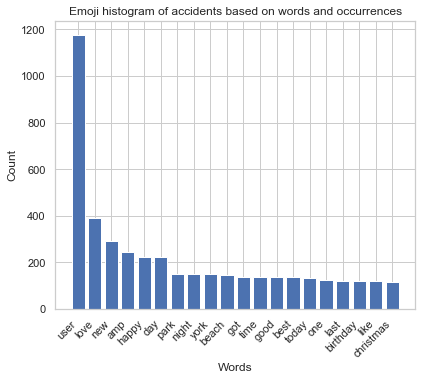

In [38]:
#Here we simply plot the distribution
fig = plt.figure(figsize = (5,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(emoji_top_20_val.keys(),emoji_top_20_val.values())
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

In [39]:
# Here we multiply the frequency with the rank

In [40]:
li =  []
counter = 1
for elm in emoji_top_20_val.values():
    li.append(elm * counter)
    counter += 1

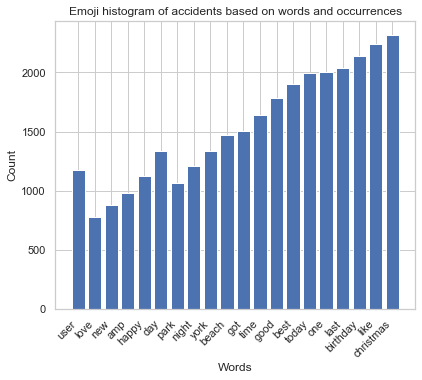

In [41]:
fig = plt.figure(figsize = (5,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(emoji_top_20_val.keys(),li)
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

In [42]:
# Raw dataset
emoji_raw_val = word_frequency(emoji_words_val_txt)
emoji_raw_train = word_frequency(emoji_words_train_txt)
emoji_raw_test = word_frequency(emoji_words_test_txt)

In [43]:
thing = most_common_words(emoji_raw_val)

In [44]:
li =  []
counter = 1
for elm in thing.values():
    li.append(elm * counter)
    counter += 1
    if counter == 51:
        break

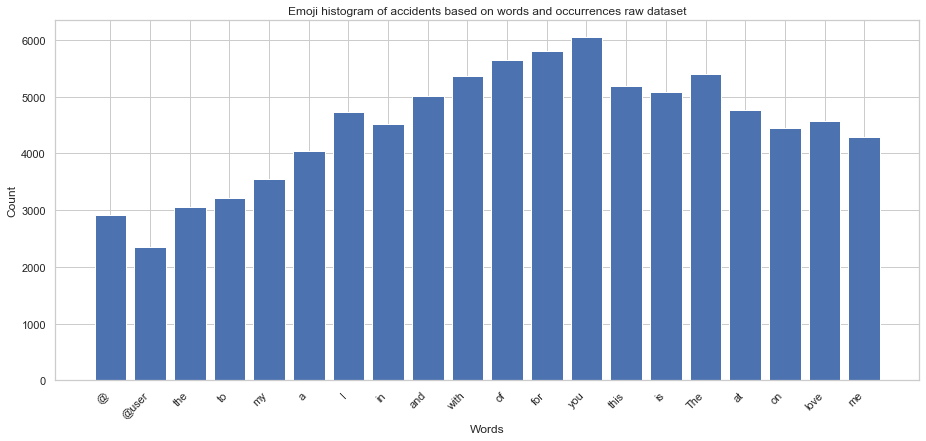

In [45]:
fig = plt.figure(figsize = (12,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(list(thing.keys())[:20],li[:20])
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences raw dataset')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

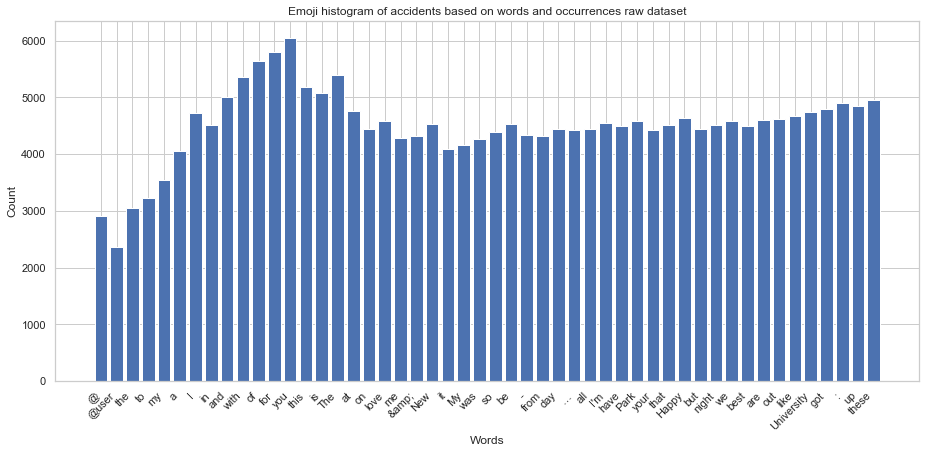

In [46]:
fig = plt.figure(figsize = (12,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(list(thing.keys())[:50],li)
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences raw dataset')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

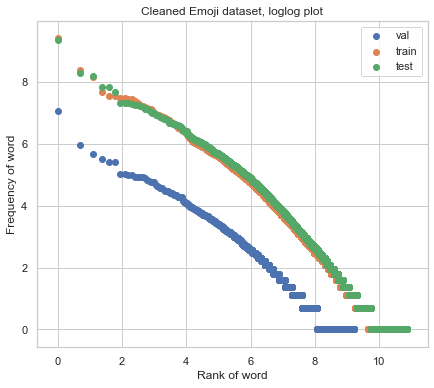

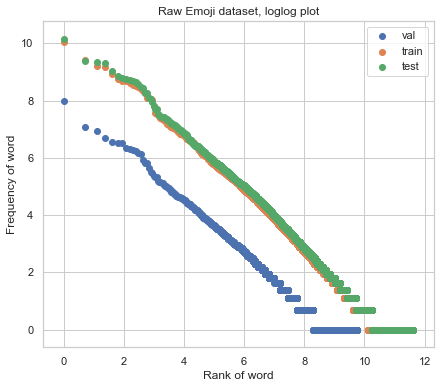

In [47]:
# Cleaned dataset:
llplot([emoji_freq_words_val, emoji_freq_words_train, emoji_freq_words_test], labels=["val", "train", "test"], title="Cleaned Emoji dataset, loglog plot")



llplot([emoji_raw_val, emoji_raw_train, emoji_raw_test], labels=["val", "train", "test"], title="Raw Emoji dataset, loglog plot")

## Type/token ratio

In [48]:
_, tokens, _, _,unique_tokens, _ ,_ = basic_statistics(emoji_text_train,printer = True)

The number of characters: 3285761
The number of tokens is: 671226
The number of sentences is: 23566
The average number of tokens per sentence is: 20
The number of unique tokens are: 45846
The tokens ratio is: 0.068
The number of total tokens after removing stopwords are: 314127


## Offensive dataset

## Size of our offensive vocabulary

In [49]:
print("Number of total words in the vocabulary " + str(len(offensive_freq_words_train)))

Number of total words in the vocabulary 16962


### Top 20 most common tokens 

In [50]:
offensive_top_20_val = top_20_most_common_words(offensive_freq_words_val)
offensive_top_20_train = top_20_most_common_words(offensive_freq_words_train)
offensive_top_20_test = top_20_most_common_words(offensive_freq_words_test)

print('Top 20 in val_text.txt:\n',offensive_top_20_val, '\n')
print('Top 20 in val_train.txt:\n',offensive_top_20_train,'\n')
print('Top 20 in val_test.txt:\n',offensive_top_20_test,'\n')

Top 20 in val_text.txt:
 {'user': 3455, 'liberals': 137, 'gun': 133, 'control': 125, 'antifa': 118, 'like': 109, 'conservatives': 107, 'maga': 98, 'people': 89, 'know': 77, 'get': 73, 'one': 71, 'trump': 69, 'think': 68, 'amp': 62, 'would': 61, 'want': 55, 'us': 52, 'going': 47, 'right': 45} 

Top 20 in val_train.txt:
 {'user': 29961, 'liberals': 1260, 'gun': 1230, 'control': 1095, 'antifa': 1047, 'like': 995, 'maga': 907, 'conservatives': 839, 'people': 830, 'amp': 615, 'get': 586, 'one': 568, 'trump': 565, 'know': 557, 'would': 507, 'think': 483, 'good': 416, 'right': 409, 'time': 349, 'us': 345} 

Top 20 in val_test.txt:
 {'user': 608, 'liberals': 81, 'conservatives': 80, 'antifa': 74, 'like': 65, 'gun': 64, 'control': 64, 'maga': 57, 'get': 51, 'one': 48, 'people': 47, 'trump': 44, 'us': 42, 'love': 38, 'want': 37, 'via': 33, 'know': 31, 'good': 31, 'going': 30, 'new': 30} 



## Top 20 least common tokens

In [51]:
offensive_least_words_val = least_common_words(offensive_freq_words_val)
offensive_least_words_train = least_common_words(offensive_freq_words_train)
offensive_least_words_test = least_common_words(offensive_freq_words_test)
print('Top 20 least common words in offensive_freq_words_val \n',offensive_least_words_val[0:20], '\n')
print('Top 20 least common words in offensive_freq_words_train \n',offensive_least_words_train[0:20], '\n')
print('Top 20 least common words in offensive_freq_words_test \n',offensive_least_words_test[0:20], '\n')

Top 20 least common words in offensive_freq_words_val 
 [('wiiu', 1), ('console', 1), ('az', 1), ('underage', 1), ('lionsden', 1), ('affect', 1), ('hazard', 1), ('club', 1), ('finger', 1), ('aid', 1), ('constituent', 1), ('disclosure', 1), ('etiquette', 1), ('moderation', 1), ('city', 1), ('ft', 1), ('richer', 1), ('sendhim', 1), ('allegation', 1), ('teen', 1)] 

Top 20 least common words in offensive_freq_words_train 
 [('countrymen', 1), ('breitbarters', 1), ('progressing', 1), ('reads', 1), ('unto', 1), ('optic', 1), ('vetsresistsquadron', 1), ('scout', 1), ('lifetimes', 1), ('obummer', 1), ('plethora', 1), ('peruse', 1), ('lighting', 1), ('torches', 1), ('checkmarks', 1), ('verifiedhate', 1), ('lmfaoooooo', 1), ('shitbiscuit', 1), ('tempe', 1), ('licensereporters', 1)] 

Top 20 least common words in offensive_freq_words_test 
 [('ibelieveblaseyford', 1), ('libreal', 1), ('snowflake', 1), ('iran', 1), ('johnkerryiranmeeting', 1), ('angels', 1), ('runs', 1), ('homers', 1), ('connects

## Zipf's Law

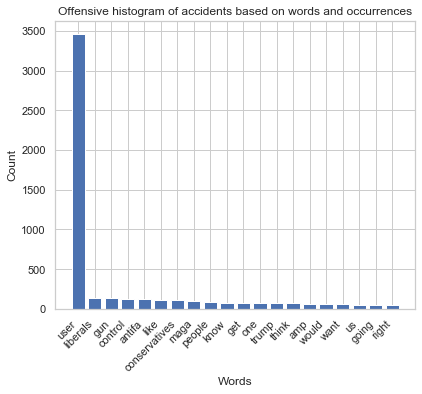

In [52]:
fig = plt.figure(figsize = (5,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(offensive_top_20_val.keys(),offensive_top_20_val.values())
fig.autofmt_xdate(rotation=45)
axes.set_title('Offensive histogram of accidents based on words and occurrences')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

In [53]:
li =  []
counter = 1
for elm in offensive_top_20_val.values():
    li.append(elm * counter)
    counter += 1

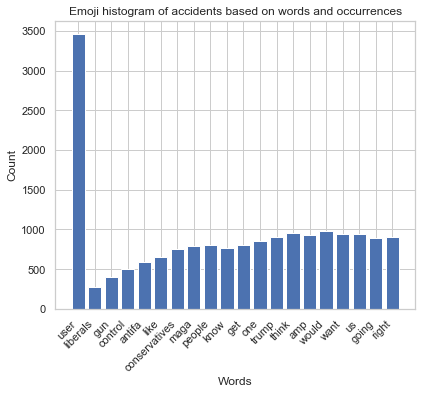

In [54]:
fig = plt.figure(figsize = (5,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(offensive_top_20_val.keys(),li)
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

In [55]:
# Raw dataset
offensive_raw_val = word_frequency(offensive_words_val_txt)
offensive_raw_train = word_frequency(offensive_words_train_txt)
offensive_raw_test = word_frequency(offensive_words_test_txt)


In [56]:
thing = most_common_words(offensive_raw_val)

In [57]:
li =  []
counter = 1
for elm in thing.values():
    li.append(elm * counter)
    counter += 1
    if counter == 51:
        break

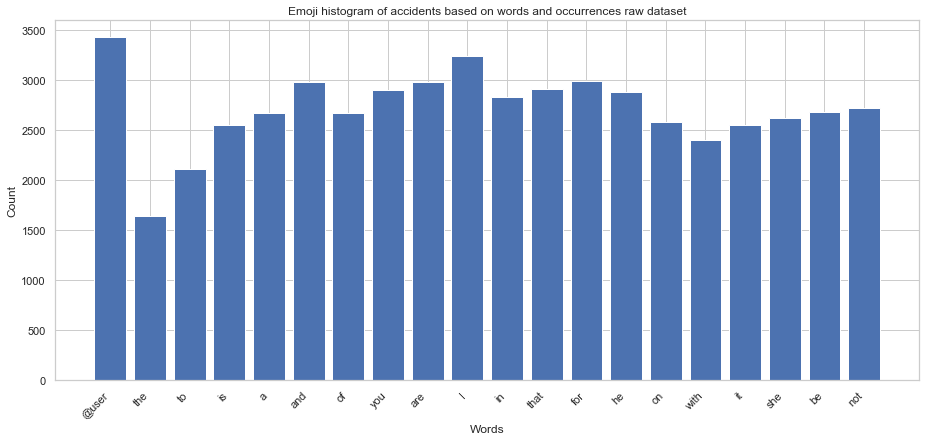

In [58]:
fig = plt.figure(figsize = (12,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(list(thing.keys())[:20],li[:20])
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences raw dataset')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

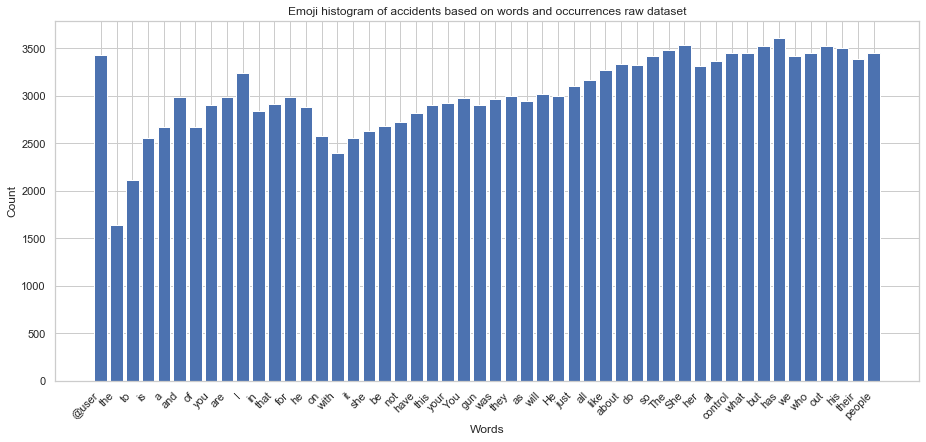

In [59]:
fig = plt.figure(figsize = (12,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(list(thing.keys())[:50],li[:50])
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences raw dataset')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

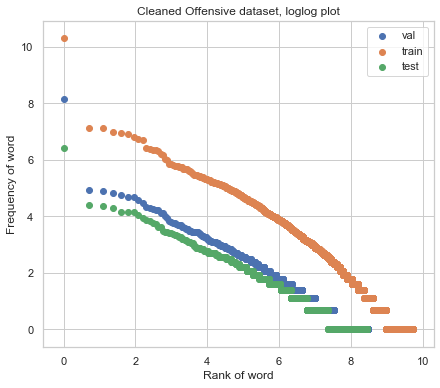

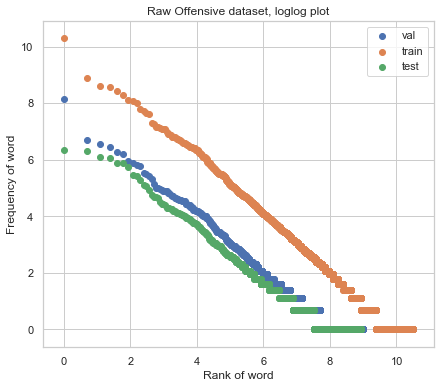

In [60]:
# Cleaned dataset:
llplot([offensive_freq_words_val, offensive_freq_words_train, offensive_freq_words_test], labels=["val", "train", "test"], title="Cleaned Offensive dataset, loglog plot")

llplot([offensive_raw_val, offensive_raw_train, offensive_raw_test], labels=["val", "train", "test"], title="Raw Offensive dataset, loglog plot")

There is an overall trend that the follows the law, however, this is has not been proven mathematicly, and our plots doesn't follow the excact distributions as described.

## Type/token ratio

In [61]:
_, tokens, _, _,unique_tokens, _ ,_ = basic_statistics(offensive_text_train,printer = True)

The number of characters: 1510503
The number of tokens is: 336416
The number of sentences is: 18122
The average number of tokens per sentence is: 14
The number of unique tokens are: 17111
The tokens ratio is: 0.051
The number of total tokens after removing stopwords are: 147302


***

## Data frames for offensive train text and offensive test text

In [62]:


train = pd.read_csv('datasets/offensive/train_text.txt', header=None, skiprows = 0, names=['tweet'], sep='\t', quoting=3)
print("Training Set:"% train.columns, train.shape, len(train))


test = pd.read_csv('datasets/offensive/test_text.txt',header=None, skiprows = 0, names=['tweet'], sep='\t', quoting=3)
print("Test Set:"% test.columns, test.shape, len(test))

Training Set: (11916, 1) 11916
Test Set: (860, 1) 860


In [63]:

index_train = [x for x in range(1, len(train.values)+1)]
index_test = [x for x in range(1, len(test.values)+1)]

train.insert(loc=0, column='id', value =index_train )
test.insert(loc=0, column='id', value =index_test )

train_labels = pd.read_csv('datasets/offensive/train_labels.txt',header=None, skiprows = 0, names=['label'], sep='\t', quoting=3)
train_labels.insert(loc=0, column='id', value=index_train)

test_labels = pd.read_csv('datasets/offensive/test_labels.txt',header=None, skiprows = 0, names=['label'], sep='\t', quoting=3)
test_labels.insert(loc=0, column='id', value =index_test )


test_df = test.merge(test_labels, on='id', how='left')
train_df = train.merge(train_labels, on='id', how='left')




In [64]:
train_df.head()

id                                              tweet  label
0   1  @user Bono... who cares. Soon people will unde...      0
1   2  @user Eight years the republicans denied obama...      1
2   3  @user Get him some line help. He is gonna be j...      0
3   4               @user @user She is great. Hi Fiona!       0
4   5  @user She has become a parody unto herself? Sh...      1

In [65]:
test_df.head()

id                                              tweet  label
0   1  #ibelieveblaseyford is liar she is fat ugly li...      1
1   2  @user @user @user I got in a pretty deep debat...      0
2   3  ...if you want more shootings and more death, ...      0
3   4  Angels now have 6 runs. Five of them have come...      0
4   5  #Travel #Movies and Unix #Fortune combined  Vi...      0

In [66]:
test_clean = clean_text(test_df, 'tweet')
train_clean = clean_text(train_df, 'tweet')

In [67]:
stop = stopwords.words('english')

train_clean['tweet'] = train_clean['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_clean.head()

id                                              tweet  label
0   1  bono cares soon people understand gain nothing...      0
1   2  eight years republicans denied obama picks bre...      1
2   3  get line help gonna fine game went could see p...      0
3   4                                     great hi fiona      0
4   5  become parody unto certainly taken heat well i...      1

In [68]:
stop = stopwords.words('english')
test_clean['tweet'] = test_clean['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

test_clean.head()

id                                              tweet  label
0   1  ibelieveblaseyford liar fat ugly libreal snowf...      1
1   2  got pretty deep debate friend told latinos tru...      0
2   3  want shootings death listen aclu black lives m...      0
3   4  angels 6 runs five come courtesy mike trout ho...      0
4   5  travel movies unix fortune combined visit sali...      0

In [69]:
test_clean['tweet'] = test_clean['tweet'].apply(lambda x: word_tokenize(x))
test_clean.head()

id                                              tweet  label
0   1  [ibelieveblaseyford, liar, fat, ugly, libreal,...      1
1   2  [got, pretty, deep, debate, friend, told, lati...      0
2   3  [want, shootings, death, listen, aclu, black, ...      0
3   4  [angels, 6, runs, five, come, courtesy, mike, ...      0
4   5  [travel, movies, unix, fortune, combined, visi...      0

In [70]:

test_clean_offensive = test_clean.loc[test_clean['label'] == 1]
test_clean_offensive.head()
#test_clean_offensive['tweet'].to_csv('test_cleaned_off_lang_df.csv',  quoting=csv.QUOTE_NONE, escapechar=' ') 

id                                              tweet  label
0    1  [ibelieveblaseyford, liar, fat, ugly, libreal,...      1
8    9  [grown, ass, woman, probably, 10, years, older...      1
10  11  [kavanaugh, disciple, anthony, kennedy, ed, li...      1
15  16  [apparently, committed, going, new, level, sin...      1
18  19  [50, cent, calls, joe, budden, bullshit, insta...      1

In [71]:
test_clean_nonoffensive = test_clean.loc[test_clean['label'] == 0]

#test_clean_nonoffensive['tweet'].to_csv('test_cleaned_non_off_lang_df.csv',  quoting=csv.QUOTE_NONE, escapechar=' ') 

test_clean_nonoffensive.head()

id                                              tweet  label
1   2  [got, pretty, deep, debate, friend, told, lati...      0
2   3  [want, shootings, death, listen, aclu, black, ...      0
3   4  [angels, 6, runs, five, come, courtesy, mike, ...      0
4   5  [travel, movies, unix, fortune, combined, visi...      0
5   6  [naturephotography, nature, birds, wild, wisco...      0

In [72]:
test_off_lists = test_clean_offensive['tweet'].values.tolist()
test_off_lists[0]

['ibelieveblaseyford',
 'liar',
 'fat',
 'ugly',
 'libreal',
 'snowflake',
 'sold',
 'get',
 'cash',
 'dems',
 'iran',
 'spoke',
 'johnkerryiranmeeting']

In [73]:
test_non_off_lists = test_clean_nonoffensive['tweet'].values.tolist()
test_non_off_lists[0]

['got',
 'pretty',
 'deep',
 'debate',
 'friend',
 'told',
 'latinos',
 'trump',
 'blacks',
 'trump',
 'paid',
 'supporters',
 'said',
 'mean',
 'antifa',
 'paid',
 'domestic',
 'terrorist',
 'said',
 'anti',
 'fascist',
 'said',
 'fascist',
 'kidding']

## Task03 - Annotation

In [ ]:
#lukas annotation
rater1=[]
with open('annotation/lukas.txt', 'r') as f:
    line = f.readline()
    while line:
        rater1.append(line.strip())
        line = f.readline()



#thomas annotation
rater2=[]
with open('annotation/thoma.txt', 'r') as f:
    line = f.readline()
    while line:
        rater2.append(line.strip())
        line = f.readline()

#martin annotation
rater3=[]
with open('annotation/martin.txt', 'r') as f:
    line = f.readline()
    while line:
        rater3.append(line.strip())
        line = f.readline()
#yasmine annotation
rater4=[]
with open('annotation/yasmine.txt', 'r') as f:
    line = f.readline()
    while line:
        rater4.append(line.strip().split()[1])
        line = f.readline()
    

        

In [ ]:
from nltk import agreement
rater1 = rater1[0:100] #lukas
rater2 = rater2[0:100] #thomas
rater3 = rater3[0:100] #martin
rater4 = rater4[0:100] #yasmine

#Please note that with yasmine the kappa agreement is only 0.2, without yasmine its 0.43, so yasmine didn't agree with the rest of us, or her dataset is f' up
taskdata=[[0,str(i),str(rater1[i])] for i in range(0,len(rater1))]+[[1,str(i),str(rater2[i])] for i in range(0,len(rater2))]+[[2,str(i),str(rater3[i])] for i in range(0,len(rater3))]#+[[3,str(i),str(rater4[i])] for i in range(0,len(rater4))]

ratingtask = agreement.AnnotationTask(data=taskdata)

#Cohen 1960 Averages naively over kappas for each coder pair.
print("kappa " +str(ratingtask.kappa()))
print("fleiss " + str(ratingtask.multi_kappa()))
print("alpha " +str(ratingtask.alpha()))
print("scotts " + str(ratingtask.pi()))

#Average observed agreement across all coders and items
print('avg', ratingtask.avg_Ao())

# Task 04 - Automatic Prediction

In [74]:
# Merging validation text and labels
val_df = merging_labels_and_sentences('datasets/offensive/val_text', 'datasets/offensive/val_labels')

# Checking for missing values
missing_val = missing_values(val_df)
# Average words devided into labels
avg_labels_word = word_count(val_df)
avg_labels_char = char_count(val_df)

print(' Average Number of Words - Offensive Tweets: ', avg_labels_word[1],'\n','Average Number of Words - Non-offensive Tweets: ', avg_labels_word[2])
print(' Average Characters in Offensive Tweets: ', avg_labels_char[1],'\n','Average Characters in Non-offensive Tweets: ', avg_labels_char[2])

print('\nNumber of missing values for each column\n',missing_val)



 Average Number of Words - Offensive Tweets:  25.569 
 Average Number of Words - Non-offensive Tweets:  22.151
 Average Characters in Offensive Tweets:  143.852 
 Average Characters in Non-offensive Tweets:  126.98

Number of missing values for each column
 id       0
tweet    0
label    0
dtype: int64


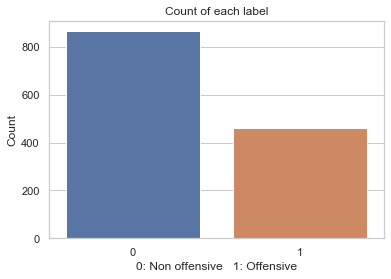

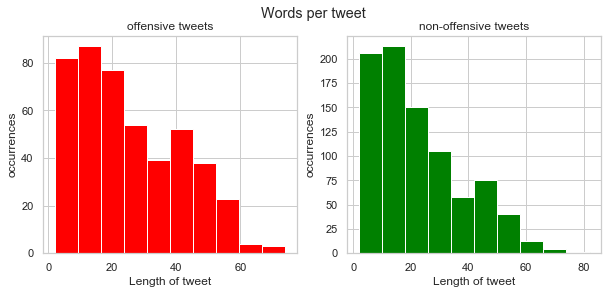

In [75]:
# Number of total labels for each class: 0 = non offensive, 1 = offensive
barplot = class_distribution(val_df,"Count of each label","0: Non offensive   1: Offensive")
# Histogram of Word count pr tweet
plot_word_count = plot_word_count(val_df)

## Term Frequency-Inverse Document Frequencies

Term Frequency-Inverse Document Frequencies (tf-Idf): Count vectors might not be the best representation for converting text data to numerical data. So, instead of simple counting, we can also use an advanced variant of the Bag-of-Words that uses the term frequency–inverse document frequency (or Tf-Idf). Basically, the value of a word increases proportionally to count in the document, but it is inversely proportional to the frequency of the word in the corpus

In [76]:
# We are splitting the data into training and test
X_train, X_test, y_train, y_test = split_dataset(val_df)

# Here we tokenize the data
X_train_tok, X_test_tok = tokenize_train_test(X_train, X_test)

# (tf-Idf)
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)


val_df['clean_text_tok']=[nltk.word_tokenize(i) for i in val_df['tweet']]
model = gensim.models.Word2Vec(val_df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv))      
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

# SGDC - bag of words

In [116]:
X_train[0:4]

1101    @user here your sign.   @user  #Liberals  @use...
1030    @user @user @user @user Maybe we need to ban k...
1188    7 car and truck ramming attacks in Europe and ...
221     @user @user @user @user @user @user @user @use...
Name: tweet, dtype: object

In [128]:
X

<4x68 sparse matrix of type '<class 'numpy.int64'>'
	with 72 stored elements in Compressed Sparse Row format>

In [129]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = X_train[0:4]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X) 
#X_test_vectors_tfidf = tfidf_vectorizer.transform(X)



val_df['clean_text_tok']=[nltk.word_tokenize(i) for i in val_df['tweet']]
model = gensim.models.Word2Vec(val_df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv))      
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)


#print(vectorizer.get_feature_names())
#print(vectorizer.get_feature_names().index("user"))
#print(X.toarray())
#print(vectorizer.vocabulary_.get(u"user"))
#print(vectorizer.get_feature_names()[60])


vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(corpus)
#print(vectorizer2.get_feature_names())
#print(X2)

NotFittedError: TfidfVectorizer - Vocabulary wasn't fitted.

# SGDC

In [78]:
#Use classification algorithm (i.e. Stochastic Logistic Regression) on training set, then assess model performance on test set
from sklearn.linear_model import SGDClassifier

lr_sgdc = SGDClassifier(loss='log', penalty='l1')
lr_sgdc.fit(X_train_vectors_w2v, y_train)
#Predict y value for test dataset
y_predict_sgdc = lr_sgdc.predict(X_test_vectors_w2v)
y_prob_sgdc = lr_sgdc.predict_proba(X_test_vectors_w2v)[:,1]



print(classification_report(y_test,y_predict_sgdc))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_sgdc))

              precision    recall  f1-score   support

           0       0.68      0.58      0.63       169
           1       0.41      0.52      0.46        96

    accuracy                           0.56       265
   macro avg       0.55      0.55      0.54       265
weighted avg       0.58      0.56      0.57       265

Confusion Matrix: [[98 71]
 [46 50]]


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


AUC: 0.5549802761341223


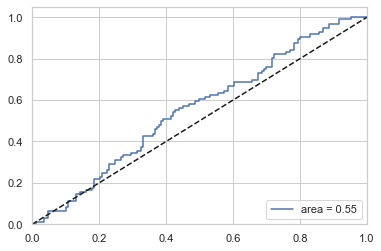

In [79]:
#Create ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pred_probas_sgdc = lr_sgdc.predict_proba(X_test_vectors_w2v)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, pred_probas_sgdc)
roc_auc = auc(fpr,tpr)
print('AUC:', roc_auc)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.show()

## Logistic regression (tf-idf)

In [80]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

lr_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.71      0.86      0.78       169
           1       0.61      0.39      0.47        96

    accuracy                           0.69       265
   macro avg       0.66      0.62      0.62       265
weighted avg       0.67      0.69      0.67       265

Confusion Matrix: [[145  24]
 [ 59  37]]
AUC: 0.7060527613412229


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


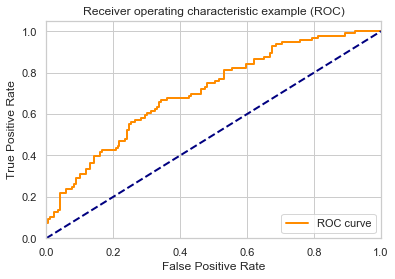

In [81]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example (ROC)')
plt.legend(loc="lower right")
plt.show()

## Logistic regression (W2v)

In [82]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)

lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.64      0.99      0.78       169
           1       0.50      0.01      0.02        96

    accuracy                           0.64       265
   macro avg       0.57      0.50      0.40       265
weighted avg       0.59      0.64      0.50       265

Confusion Matrix: [[168   1]
 [ 95   1]]
AUC: 0.5611439842209073


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


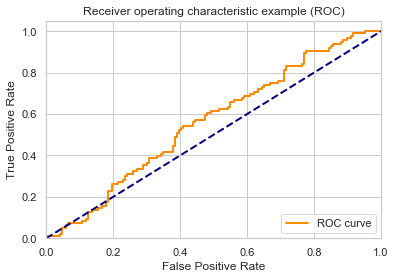

In [83]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example (ROC)')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes

In [84]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train) 

 #Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.65      1.00      0.78       169
           1       1.00      0.03      0.06        96

    accuracy                           0.65       265
   macro avg       0.82      0.52      0.42       265
weighted avg       0.77      0.65      0.52       265

Confusion Matrix: [[169   0]
 [ 93   3]]
AUC: 0.6527366863905326


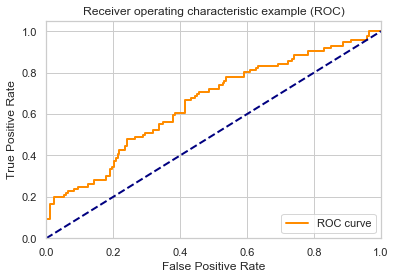

In [85]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example (ROC)')
plt.legend(loc="lower right")
plt.show()

In [86]:
# Sa
model_prediction_preprocessed_data(val_df).to_csv('model_predict_proc_validation.csv')

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [87]:
model_prediction_nonprocessed_data(val_df).to_csv('model_predict_nonproc_validation.csv')

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
